<h1 align="center"><strong><font size="6"> The Soccer-Factor-Model <br> Identifying a Soccer-Player's Skill/Ability via Bayesian Logistic Regression </h1></strong></font>

### What's the Soccer-Factor-Model all about?

**The Inspiration**

The Soccer-Factor-Model (SFM) is inspired by the academic literature on asset-pricing along the following lines:

> 1. Factor Models à la [Fama & French](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1540-6261.1992.tb04398.x) use "factors" to explain the cross-section of stock returns. <br>
 --> **here**: we use "Team-Factors" to explain away the role of the team's strength in making a given player $i$ score a goal.

> 2. There is some literature on the skill of investment fund managers that works in a similar way: "explain away" that proportion of a fund's returns that is related to economic fundamentals (e.g. [Coggin, Fabozzi, Rahman (1993)](https://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.1993.tb04029.x); [Fama & French (2010)](https://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.2010.01598.x); [Berg & van Binsbergen (2015)](https://www.sciencedirect.com/science/article/pii/S0304405X15000628)):
\begin{align}
  r_{p,t} = \alpha_p + \sum^N_{n=1} \beta_n \, f_{n,t} + \varepsilon_{p,t}
\end{align} <br>
 where $r_{p,t}$ is portfolio $p$'s return in excess of the risk-free rate (e.g. short-term U.S. government bonds). $f_{n,t}$ measures the return that one could generate by following the strategy prescribed by **factor $n$**, and $\varepsilon_{p,t}$ is a random error that is usually assumed to be mean zero. <br> The parameter of interest here is $\mathbf{\alpha_p}$. It is that part of a portfolio's conditional mean, that is not to be explained by the factors $f_{1,t},...,f_{N,t}$, and is a measure of the portfolio manager's **skill/ability**. Said differently: it quantifies the manager's ability to generate returns **beyond** the return you would have received by just following the investment strategy dictated by the factors.

The **SFM** is a direct analogy to the model above, where we substitute the target (the portfolio return $r_{p,t}$) with a measure of player $i$'s *observed performance* (OP$_{i,m,s}$) in match $m$ of season $s$.

**Factors** ($f = 1,...,F$, assembled in our feature matrix ($\mathbf{X} \in \mathbb{R}^F$)) are intended to help us understand which part of a player's *observed performance* is due to the strength of the **team** ( $\mathbf{X}_i \, \mathbf{\beta}$ ) that player $i$ is playing for, and which proportion of **OP**$_{i}$ is due to player $i$'s **own** skill/ability ($\alpha_i$) . In that sense, $\alpha_i$ is our main parameter of interest as it gives us a measure of the **innate skill/ability** of player $i$.


## Kick-Off

In [1]:
# -------------------------------------- USER INTERACTION -------------------------------------- #

# --- Set the directory to the datafile ('SFM_data_byPlayer.csv'):
directory_data = '../10_data'

# -------------------------------------- USER INTERACTION -------------------------------------- #

## Data preparation

In [2]:
from typing import List, Union

import arviz as az
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from matplotlib.lines import Line2D
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

pm.__version__

'5.16.2'

In [3]:
az.style.use("arviz-whitegrid")
plt.rcParams["figure.figsize"] = [12, 5]
%config InlineBackend.figure_format = 'retina'
seed = sum(map(ord, "sfm"))
rng = np.random.default_rng(seed)

In [4]:
factors_numeric = ["points_diff"]
other_factors = ["center", "home_pitch"]
other_factors = ["home_pitch"]
factors = other_factors + factors_numeric

In [5]:
#complete_data = pd.read_csv("../../10_data/101_SFM/SFM_data_byPlayer.csv")
complete_data = pd.read_csv(f"{directory_data}/SFM_data_byPlayer.csv")

complete_data["goal"] = complete_data["goal"].astype(int)
complete_data["goals_in_match"] = complete_data["goals_in_match"].astype(int)

complete_data["kick_off"] = pd.to_datetime(
    complete_data["kick_off"], yearfirst=True
).dt.normalize()

# compute season number for each player, ~maturity of player
complete_data["season_nbr"] = complete_data.groupby(["name_player"])[
    "season"
].transform(lambda x: x.factorize(sort=True)[0])

# --- Compute share of games played as center or winger
complete_data["share_center"] = complete_data["N_games_center"] / complete_data[
    ["N_games_left", "N_games_center", "N_games_right"]
].sum(axis=1)
# --- Unfortunately: drop NAs...
complete_data = complete_data.dropna(subset="share_center").reset_index(drop=True)

# idiosyncracy: remove Henry's last games in 2011/12
complete_data = complete_data[
    ~(
        (complete_data["name_player"] == "thierry-henry")
        & (complete_data["season"] == "2011/12")
    )
]

complete_data = complete_data.sort_values(["name_player", "kick_off"]).reset_index(
    drop=True
)
complete_data

Unnamed: 0  goal  goals_in_match  goals_in_first_half  \
0           29861     0               0                  0.0   
1           29862     0               0                  0.0   
2           29863     0               0                  0.0   
3           29864     0               0                  0.0   
4           29865     0               0                  0.0   
...           ...   ...             ...                  ...   
33673       25607     0               0                  0.0   
33674       25608     0               0                  0.0   
33675       25609     0               0                  0.0   
33676       25610     0               0                  0.0   
33677       25611     1               1                  0.0   

       goals_in_second_half  goals_scored_avg_minutes_left  points_team  \
0                       0.0                            0.0          0.0   
1                       0.0                            0.0         24.0   
2                       0.0                            0.0         27.0   
3                       0.0                            0.0         27.0   
4                       0.0                            0.0         30.0   
...                     ...                            ...          ...   
33673                   0.0                            0.0         80.0   
33674                   0.0                            0.0          0.0   
33675                   0.0                            0.0         47.0   
33676                   0.0                            0.0         47.0   
33677                   1.0                           45.0         48.0   

       points_opp  goalsscored_inGame_team  goalsscored_inGame_opp  ...  \
0             0.0                      2.0                     4.0  ...   
1            17.0                      1.0                     0.0  ...   
2            39.0                      0.0                     3.0  ...   
3            25.0                      1.0                     0.0  ...   
4            11.0                      1.0                     1.0  ...   
...           ...                      ...                     ...  ...   
33673        47.0                      3.0                     0.0  ...   
33674         0.0                      2.0                     0.0  ...   
33675        28.0                      1.0                     2.0  ...   
33676        25.0                      1.0                     1.0  ...   
33677        35.0                      1.0                     3.0  ...   

       goalsscored_diff  goal_balance_team  goal_balance_opp  \
0                   0.0                0.0               0.0   
1                   2.0               -3.0              -9.0   
2                 -15.0               -2.0              22.0   
3                  -5.0               -5.0              -5.0   
4                   8.0               -4.0             -24.0   
...                 ...                ...               ...   
33673               3.0               33.0              -1.0   
33674               0.0                0.0               0.0   
33675              14.0               11.0              -3.0   
33676              14.0               10.0             -16.0   
33677               9.0               10.0               4.0   

       goal_balance_diff  points_diff  goalsscored_share_player_team  \
0                    0.0          0.0                       0.000000   
1                    6.0          7.0                       0.000000   
2                  -24.0        -12.0                       0.000000   
3                    0.0          2.0                       0.000000   
4                   20.0         19.0                       0.000000   
...                  ...          ...                            ...   
33673               34.0         33.0                       0.140625   
33674                0.0          0.0                       0.000000   
33675              

In [6]:
players_ordered = complete_data["name_player"].sort_values().unique()
players_ordered.shape

(144,)

In [7]:
assert complete_data["name_player"].sort_values().unique().shape[0] == len(
    players_ordered
)

## Why an Ordered Categorical likelihood

Let's give a good look at the frequency of each count in the data. First in terms of probability:

In [8]:
complete_data["goals_in_match"].value_counts(normalize=True).round(4)

goals_in_match
0    0.6918
1    0.2399
2    0.0563
3    0.0106
4    0.0012
5    0.0002
Name: proportion, dtype: float64

Then raw counts:

In [9]:
complete_data["goals_in_match"].value_counts()

goals_in_match
0    23299
1     8079
2     1896
3      356
4       40
5        8
Name: count, dtype: int64

**The counts for 3+ goals are extremely rare compared to 0, 1 and 2 goals**. This means using a Poisson likelihood is not really appropriate, as the Poisson expects much higher counts on the right tail of the distribution.

In this case, it makes more sense to use a **Categorical likelihood with categories $[0, 1, 2, 3+]$**. That may sound counter-intuitive, as in theory the number of goals a player can score per game has no upper bound (hence the Poisson), but in practice, we see this number exceeds 2 less than 2% of the time.

As a result, lumping together any observations equal or higher to 3, and treating each of the 4 events as a distinct category, with its own probability of success, makes more sense and allows for a more sensical model.

In [10]:
# lump together values >= 3
complete_data["goals_cats"] = np.where(
    complete_data["goals_in_match"] >= 3, 3, complete_data["goals_in_match"]
)

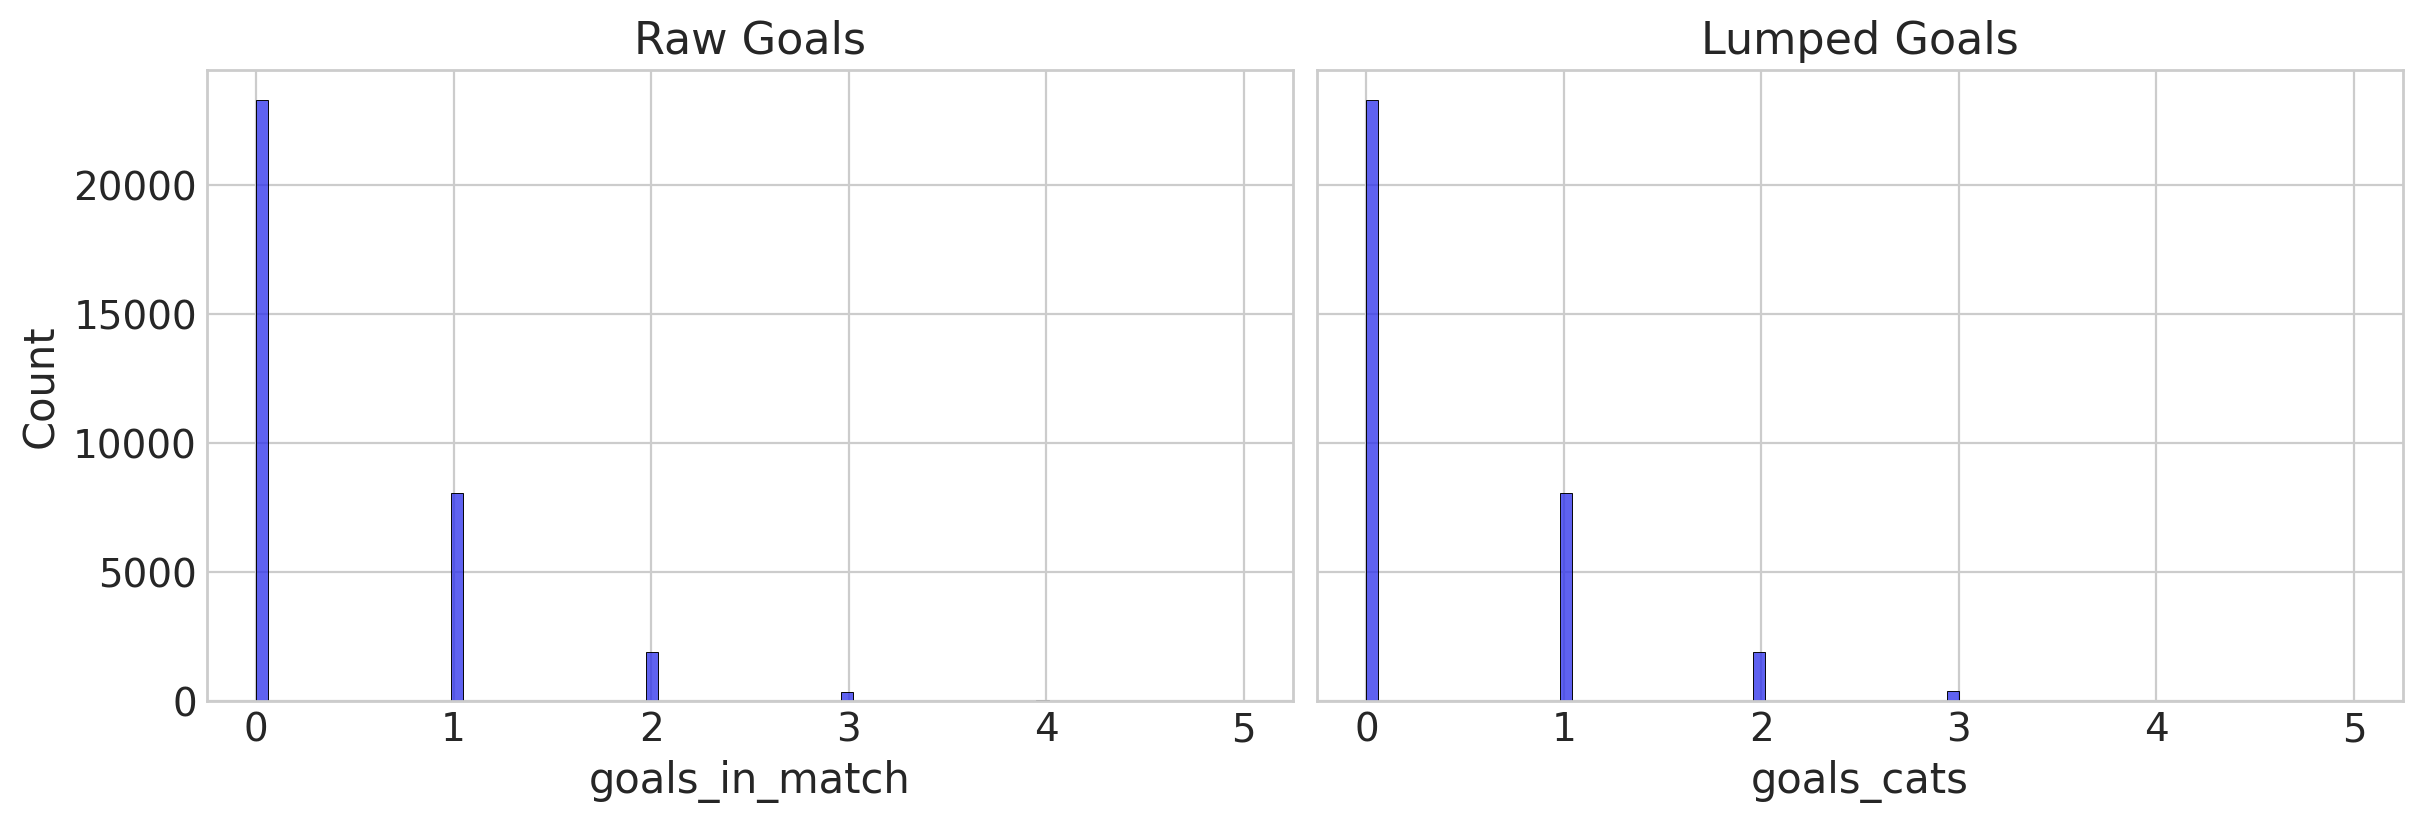

In [11]:
_, (left, right) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
sns.histplot(complete_data, x="goals_in_match", ax=left)
left.set(title="Raw Goals")
sns.histplot(complete_data, x="goals_cats", ax=right)
right.set(title="Lumped Goals");

We can see that this virtually doesn't change anything, because the frequencies are so low for high counts. We can now implement the model.

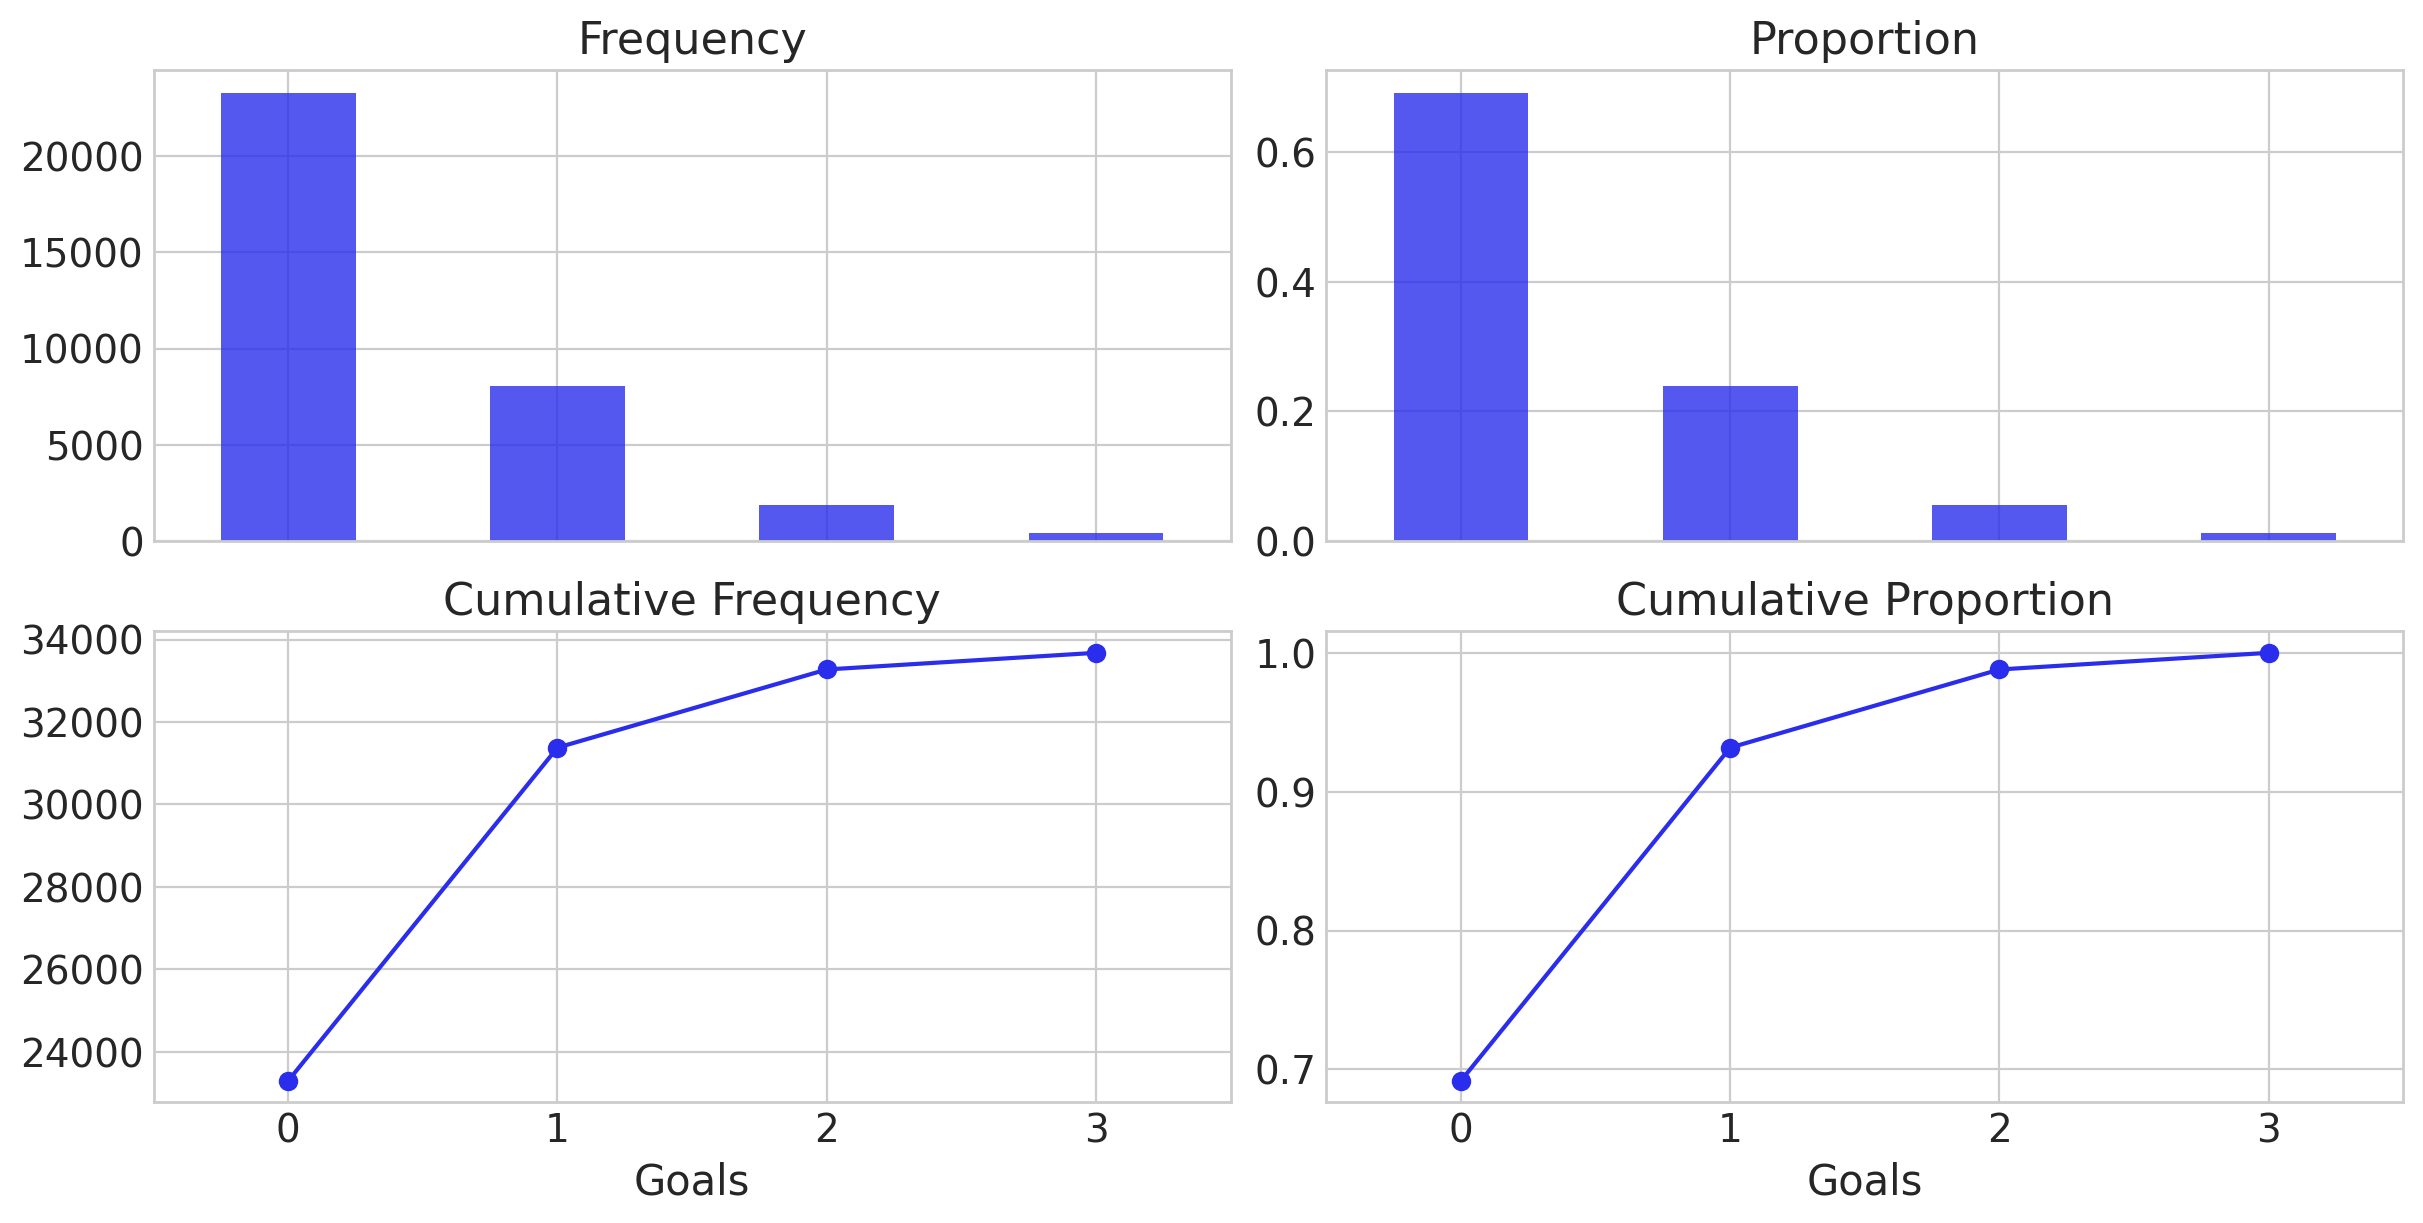

In [12]:
_, axes = plt.subplot_mosaic(
    [
        ["Frequency", "Proportion"],
        ["Cumulative Frequency", "Cumulative Proportion"],
    ],
    figsize=(12, 6),
    sharex=True,
    layout="constrained",
)

complete_data["goals_cats"].sort_values().value_counts(sort=False).plot(
    kind="bar", alpha=0.8, rot=0, ax=axes["Frequency"]
)
axes["Frequency"].set(xlabel="Goals", title="Frequency")

complete_data["goals_cats"].sort_values().value_counts(sort=False, normalize=True).plot(
    kind="bar", alpha=0.8, rot=0, ax=axes["Proportion"]
)
axes["Proportion"].set(xlabel="Goals", title="Proportion")

complete_data["goals_cats"].sort_values().value_counts(sort=False).cumsum().plot(
    marker="o", rot=0, ax=axes["Cumulative Frequency"]
)
axes["Cumulative Frequency"].set(xlabel="Goals", title="Cumulative Frequency")

complete_data["goals_cats"].sort_values().value_counts(
    sort=False, normalize=True
).cumsum().plot(marker="o", rot=0, ax=axes["Cumulative Proportion"])
axes["Cumulative Proportion"].set(xlabel="Goals", title="Cumulative Proportion");

In [13]:
complete_data["goals_cats"].sort_values().value_counts(sort=False).cumsum()

goals_cats
0    23299
1    31378
2    33274
3    33678
Name: count, dtype: int64

In [14]:
complete_data["goals_cats"].sort_values().value_counts(sort=False, normalize=True)

goals_cats
0    0.691817
1    0.239890
2    0.056298
3    0.011996
Name: proportion, dtype: float64

## Factor standardization

In [15]:
factors_numeric_train = complete_data[factors_numeric]

scaler = StandardScaler()
# Fit the scaler on the training data and transform the data
factors_numeric_sdz = pd.DataFrame(
    scaler.fit_transform(factors_numeric_train), columns=factors_numeric
)

# Add the non-numeric factor to the standardized DataFrame
factors_sdz = factors_numeric_sdz.copy()
#factors_sdz[other_factors] = complete_data[["share_center", "home_pitch"]]
factors_sdz[other_factors] = complete_data[["home_pitch"]]

# make sure the order is the same as the PyMC coords later on
factors_sdz = factors_sdz[factors]

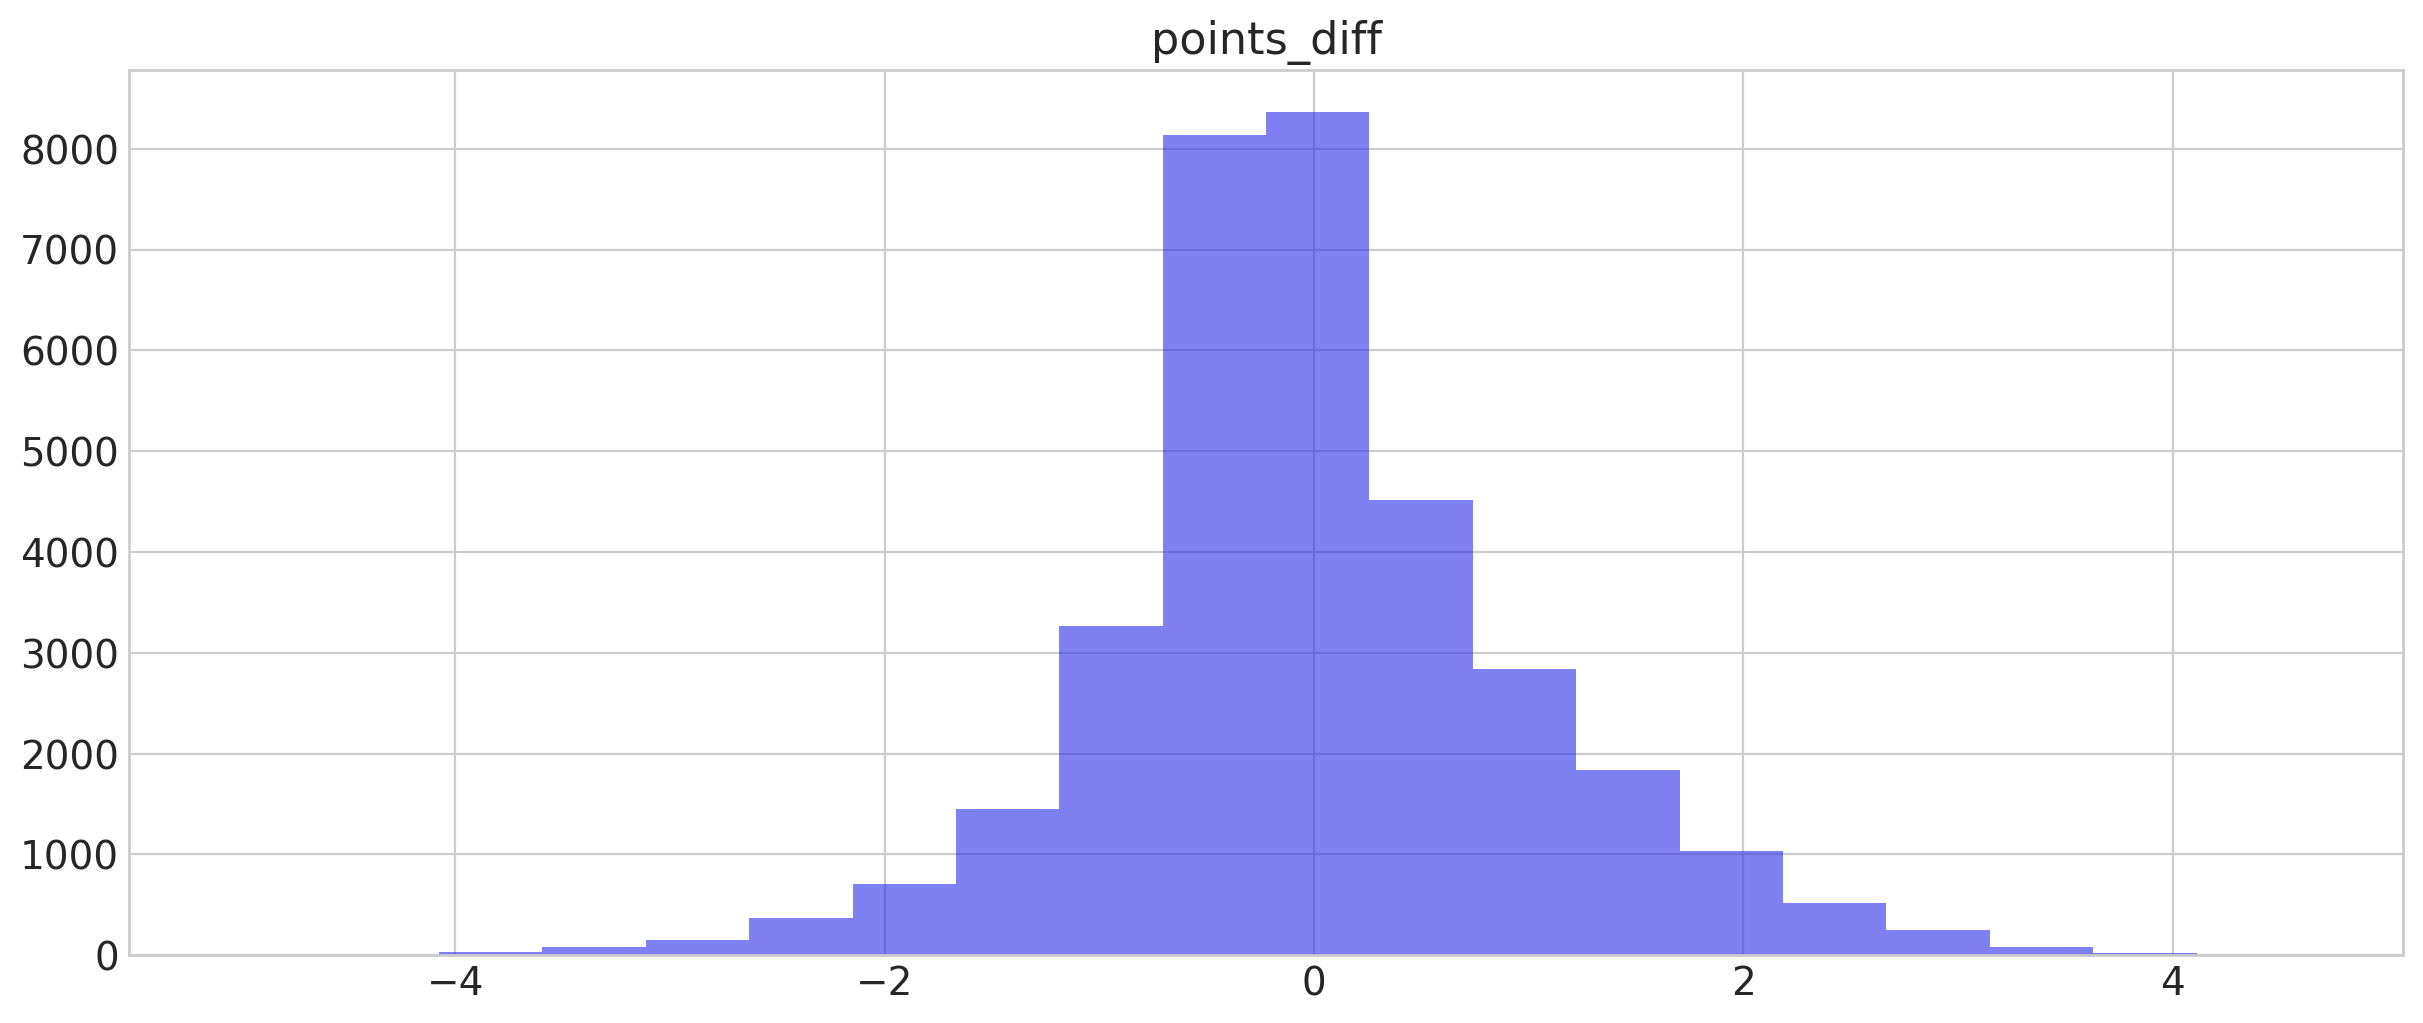

In [16]:
factors_numeric_sdz.hist(alpha=0.6, bins=20);

## HSGP Parameters

In the model below, we use a linear trend on the season term for each player. That's because we assume that the effects of maturity, as we call it, are mostly non-linear for each player: all else being equal, we don't expect players to _suddenly_ become very good or very bad.

Once we've taken this trend into account though, we do envision possibilities for the goal performance of a player to exhibit non-linear fluctuations (they got injured and don't come back well; they didn't prepare well enough during the summer and lag behind in the second half of the season; on the contrary, they prepared too strongly during the summer and are exhausted once Spring arrives, etc.).

To handle these effects, we'll use the new [Hilbert-Space decomposition](https://arxiv.org/abs/2004.11408) of the Gaussian Process (HSGP), which is also [available in PyMC](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.HSGP.html). So instead of using a classic linear trend on `days_since_first_week` (as we do on `season`), we'll use an HSGP.

### Choosing the approximation parameters

HSGP is mainly defined by two parameters, `m` and `c`, respectively the number of basis vectors and the multiplier determining the boundary of the approximation (see [this](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Basic.html) for more details). PyMC actually has a helper function to help us choose `m` and `c`:

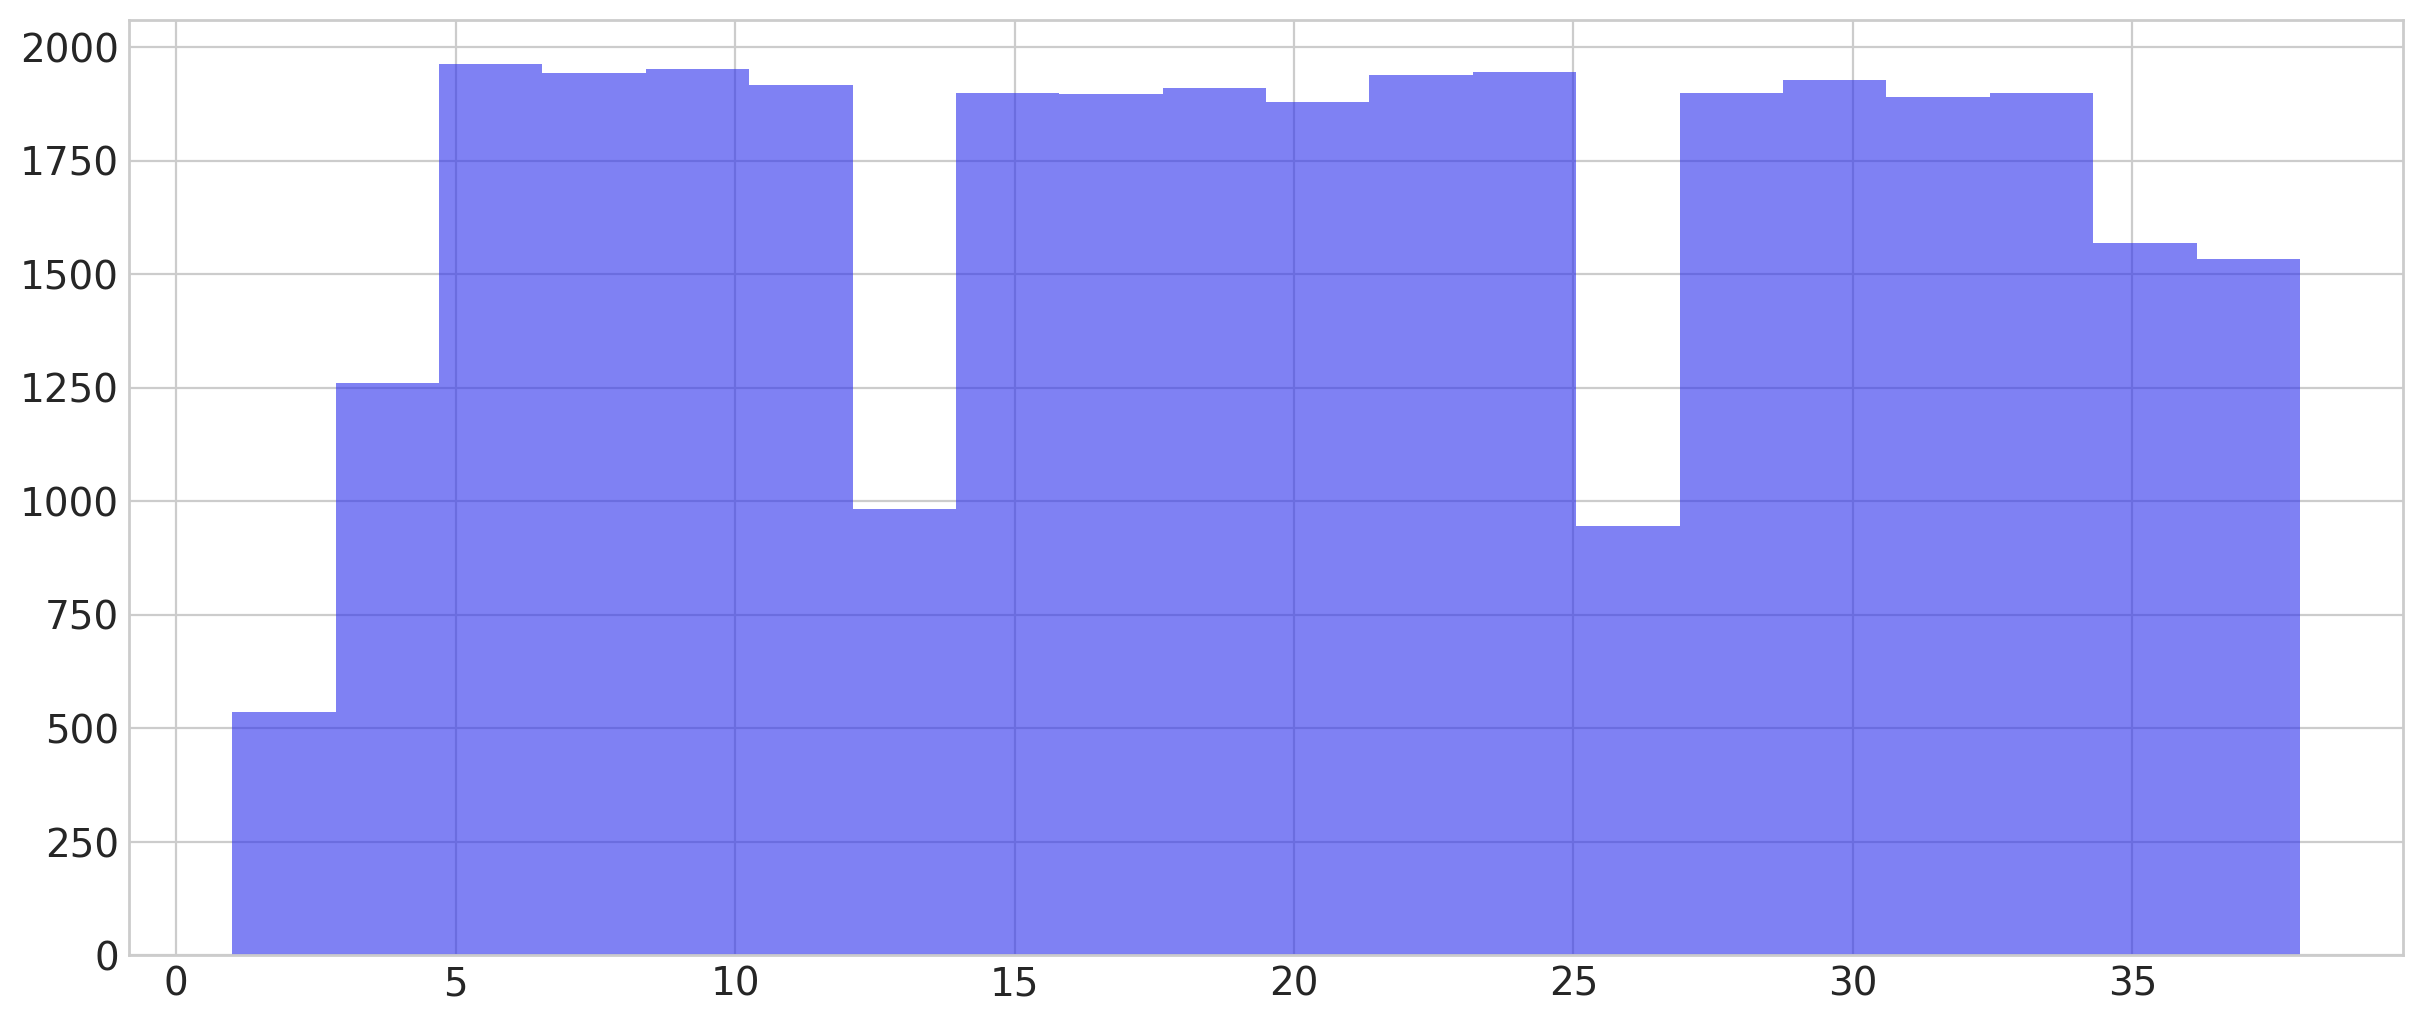

In [17]:
complete_data.gameday.hist(alpha=0.6, bins=20);

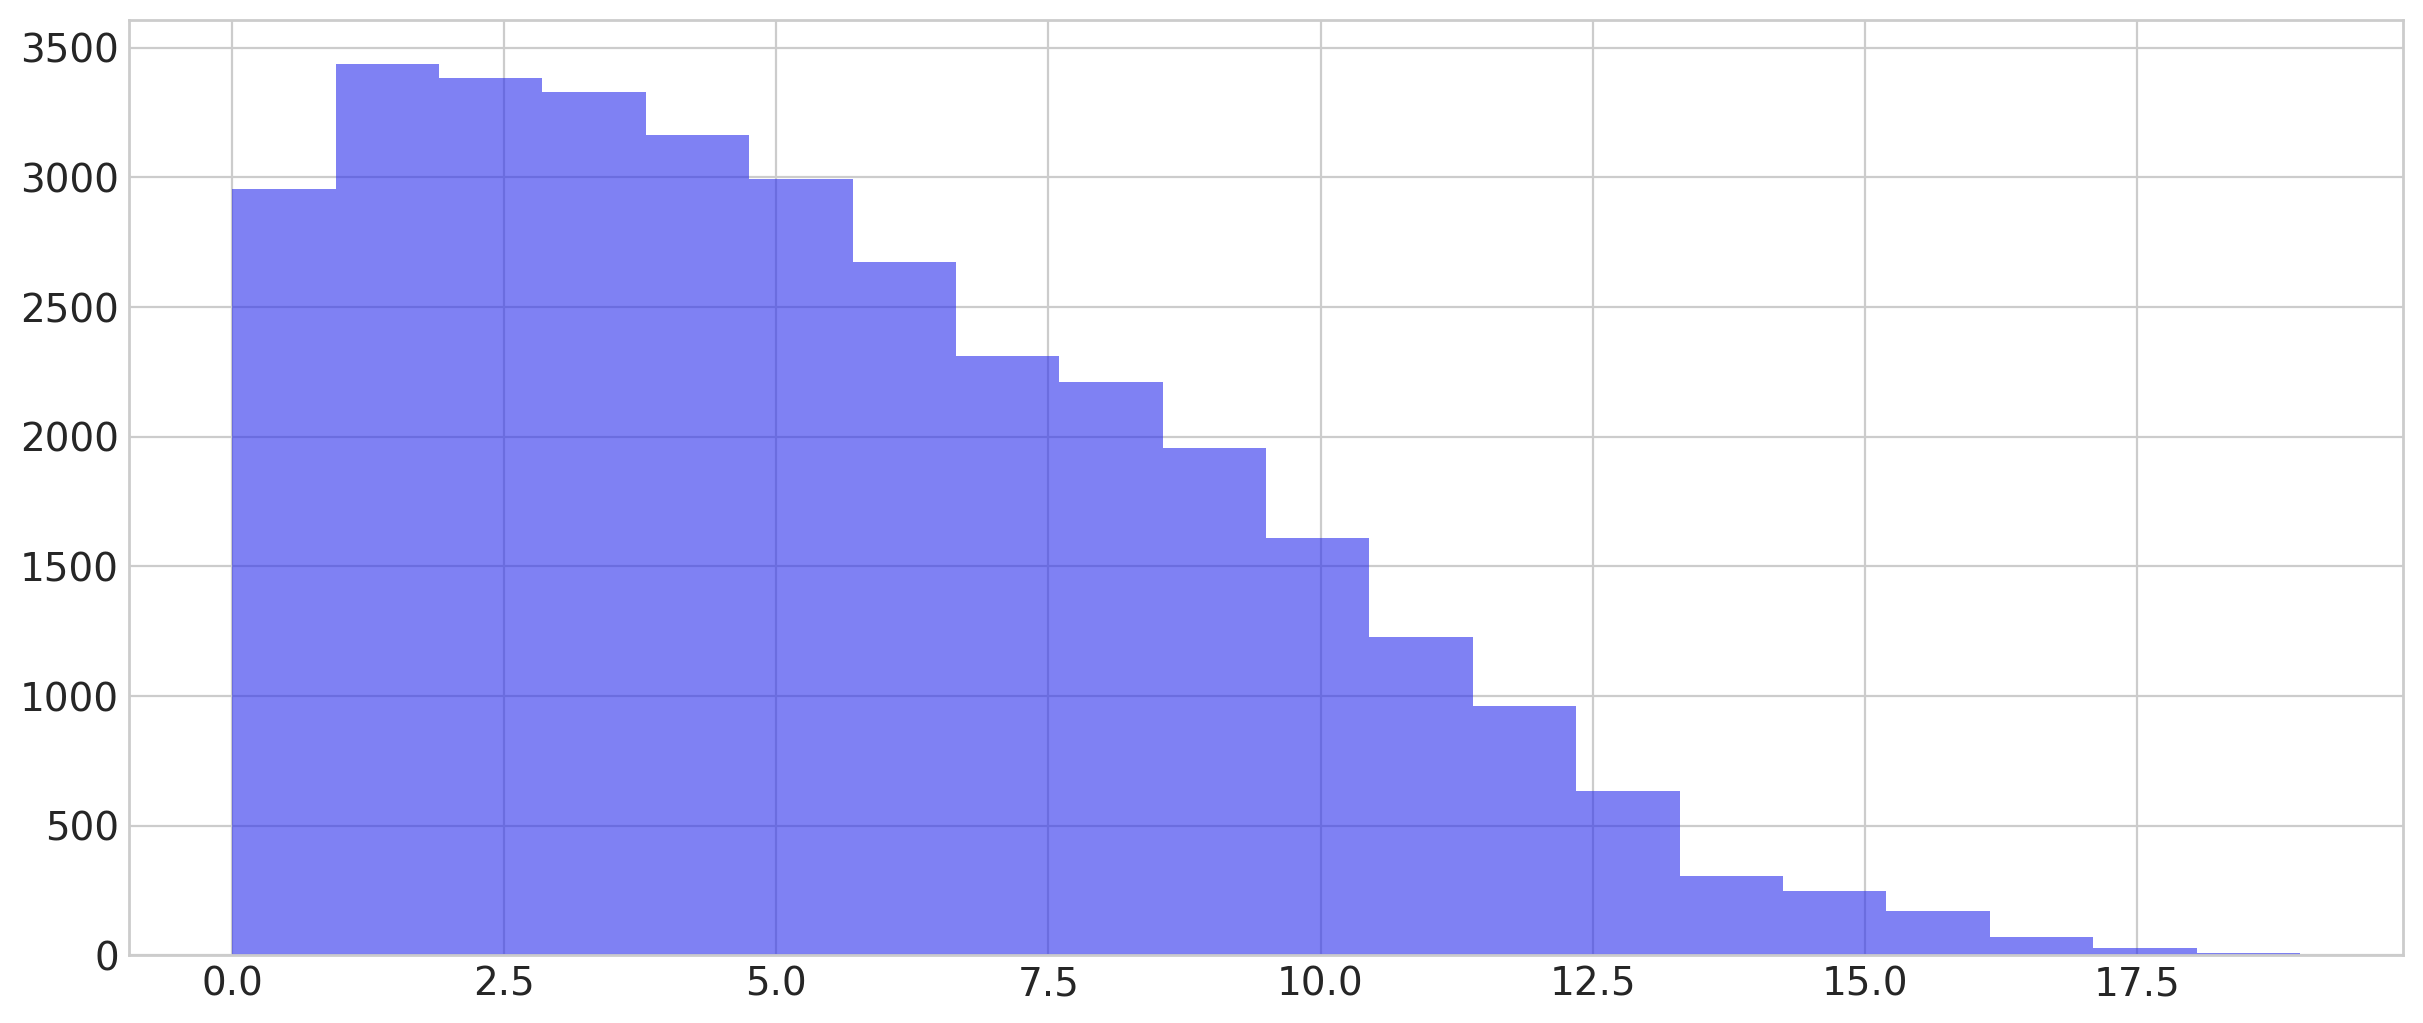

In [18]:
complete_data.season_nbr.hist(alpha=0.6, bins=20);

In [19]:
m_within, c_within = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[0, complete_data.gameday.max()],
    lengthscale_range=[5, 25],
    cov_func="matern52",
)

print("Recommended smallest number of basis vectors (m):", m_within)
print("Recommended smallest scaling factor (c):", np.round(c_within, 1))

m_long, c_long = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[0, complete_data.season_nbr.max()],
    lengthscale_range=[2, 6],
    cov_func="matern52",
)

print("Recommended smallest number of basis vectors (m):", m_long)
print("Recommended smallest scaling factor (c):", np.round(c_long, 1))

Recommended smallest number of basis vectors (m): 54
Recommended smallest scaling factor (c): 5.4
Recommended smallest number of basis vectors (m): 32
Recommended smallest scaling factor (c): 2.6


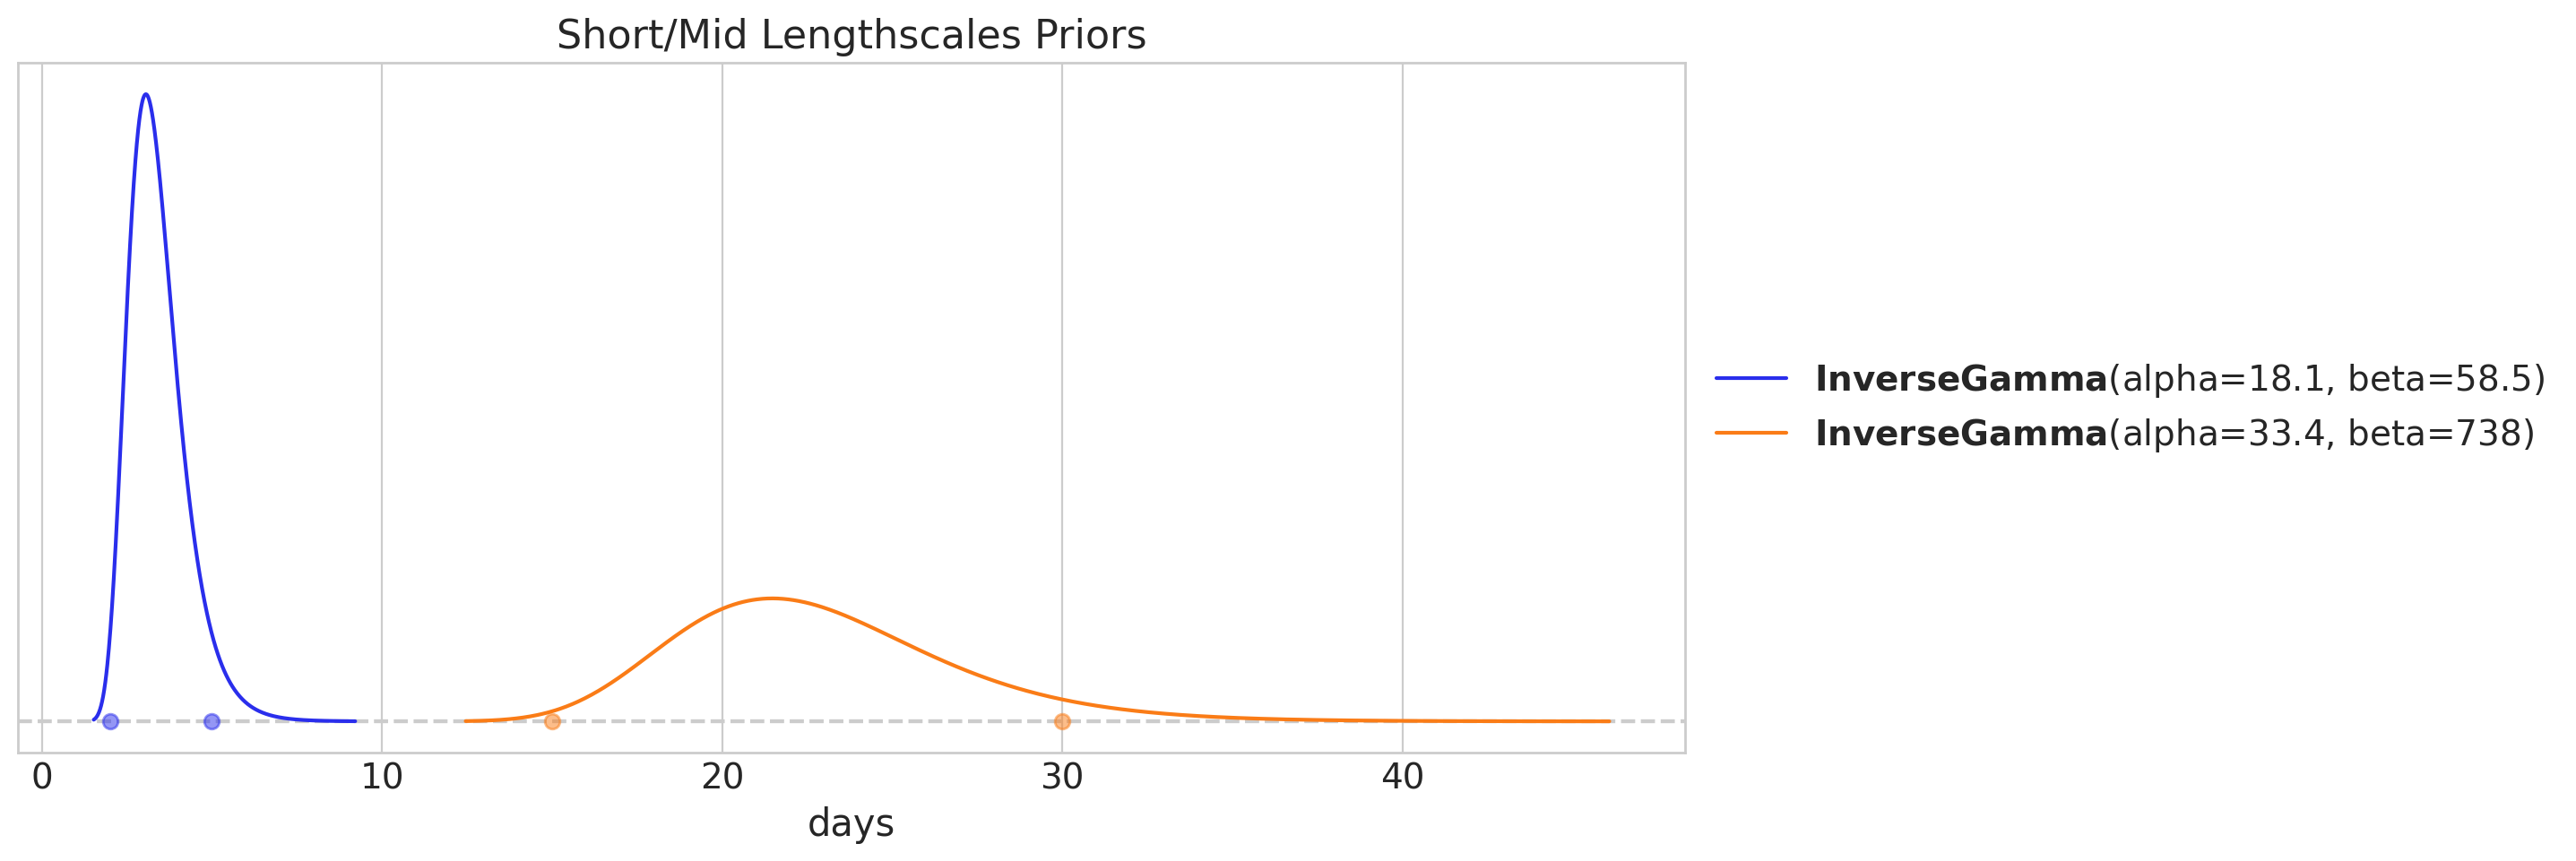

In [20]:
ls_short_dist, _ = pz.maxent(pz.InverseGamma(), 2, 5)
ls_medium_dist, ax = pz.maxent(pz.InverseGamma(), 15, 30)
ax.set(title="Short/Mid Lengthscales Priors", xlabel="days");

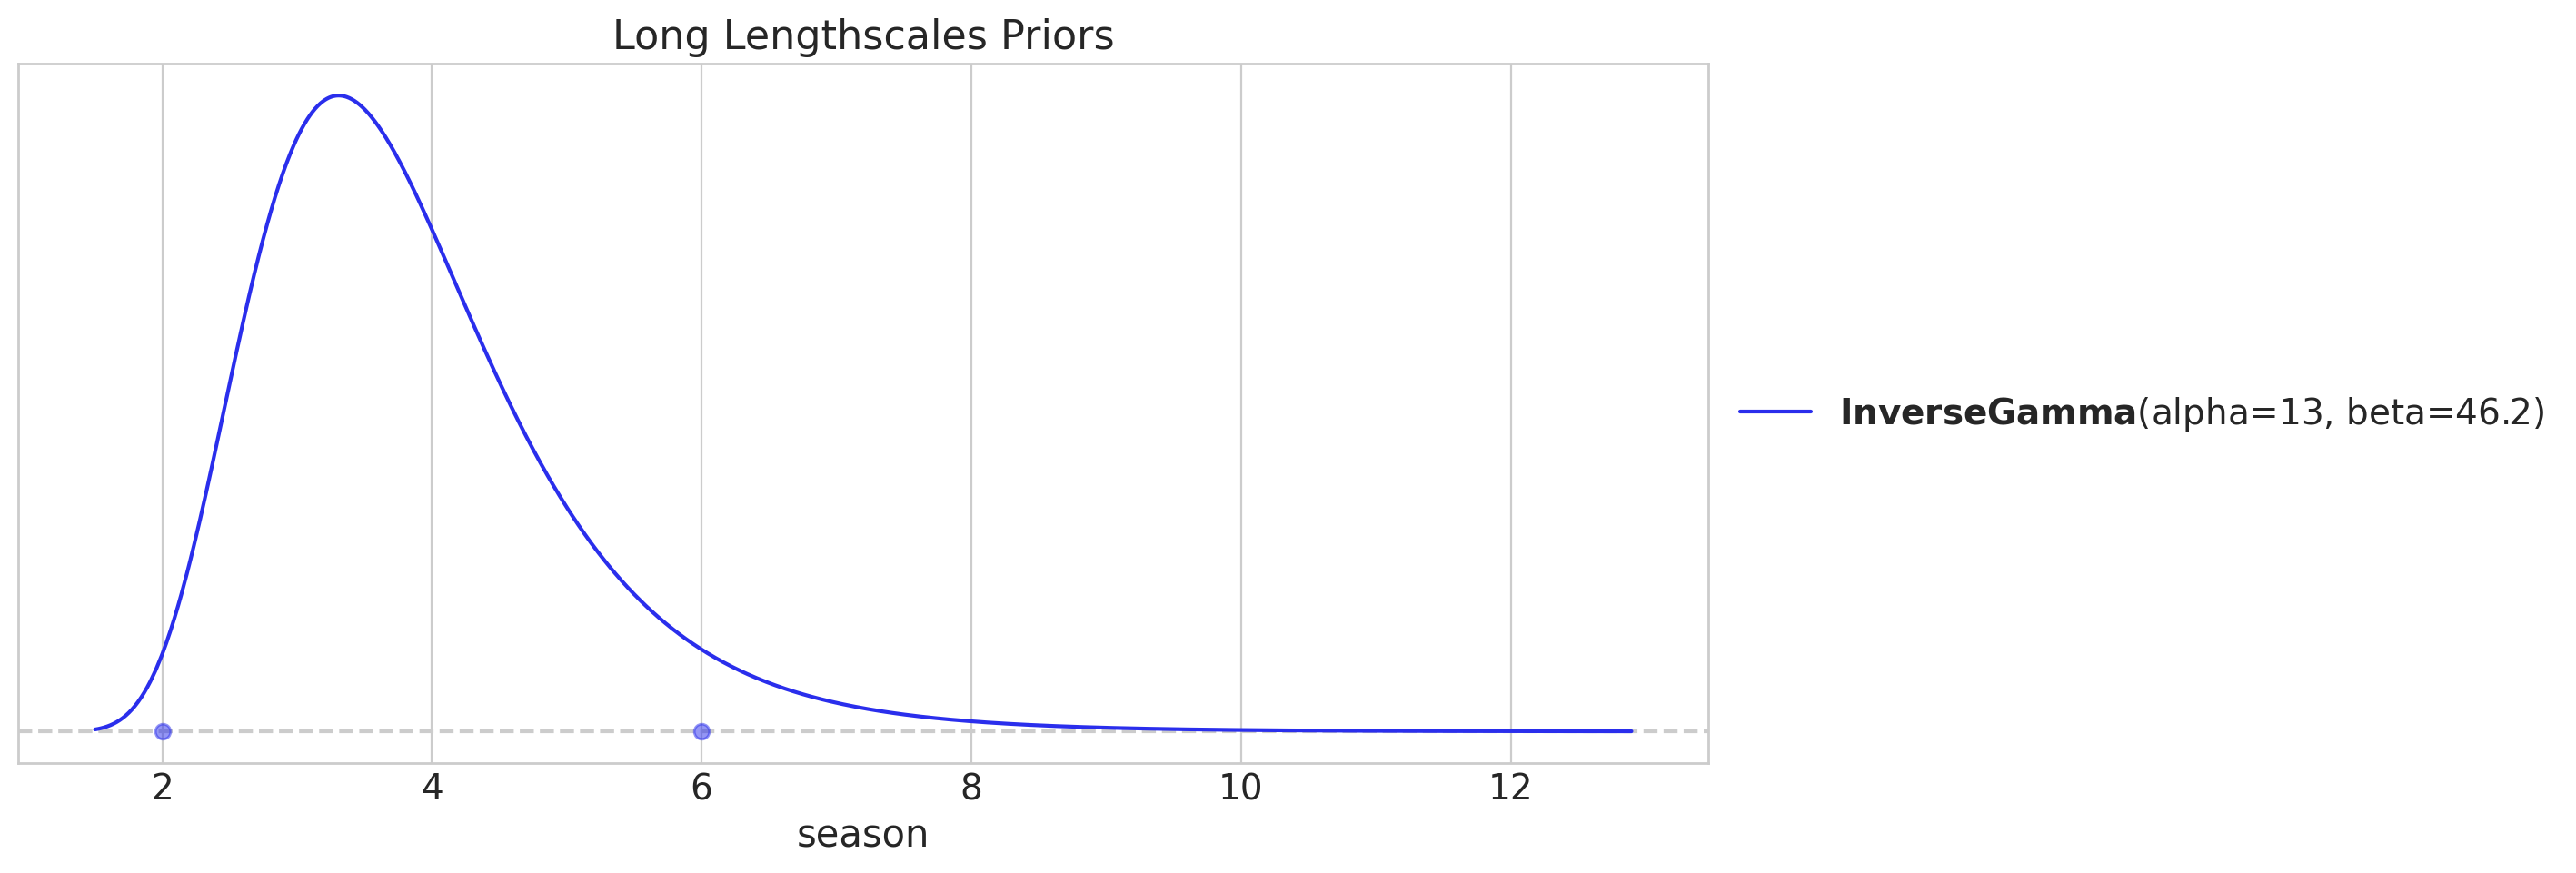

In [21]:
ls_long_dist, ax = pz.maxent(pz.InverseGamma(), 2, 6)
ax.set(title="Long Lengthscales Priors", xlabel="season");

We can now implement our PyMC model. It'll be a big one, but we'll take it step by step.

## PyMC Model

First, let's define some variables we'll use throughout our model building process:

In [22]:
# these don't change between train and test
unique_gamedays = complete_data["gameday"].sort_values().unique()
unique_seasons = complete_data["season_nbr"].sort_values().unique()

In [23]:
# these can change
player_idx = pd.Categorical(
    complete_data["name_player"], categories=players_ordered
).codes
gameday_idx = pd.Categorical(
    complete_data["gameday"],
    categories=unique_gamedays,
).codes

COORDS = {
    "event": complete_data["goals_cats"].factorize(sort=True)[1],
    "factor": factors,
    "gameday": unique_gamedays,
    "obs_id": complete_data.index,
    "player": players_ordered,
    "season": unique_seasons,
    "timescale": ["short", "medium", "long"],
}

Then, let's define the data containers for our model:

### Data containers

In [24]:
with pm.Model(coords=COORDS) as SFM_rlp:

    # Data containers
    factor_data = pm.Data(
        "factor_data", factors_sdz.to_numpy(), dims=("obs_id", "factor")
    )
    gameday_id = pm.Data("gameday_id", gameday_idx, dims="obs_id")
    player_id = pm.Data("player_id", player_idx, dims="obs_id")
    season_id = pm.Data(
        "season_id", complete_data["season_nbr"].to_numpy(), dims="obs_id"
    )
    goals_obs = pm.Data(
        "goals_obs", complete_data["goals_cats"].to_numpy(), dims="obs_id"
    )

### Players' skills

For the priors we use [those recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations).

In [25]:
with SFM_rlp:
    intercept_sigma = 5
    sd = pm.Exponential("player_effect_diversity", 1)

    baseline_sigma = pt.sqrt(intercept_sigma**2 + sd**2 / len(COORDS["player"]))
    baseline = baseline_sigma * pm.Normal("baseline")

    player_effect = pm.Deterministic(
        "player_effect",
        baseline + pm.ZeroSumNormal("player_effect_raw", sigma=sd, dims="player"),
        dims="player",
    )

### HSGPs

#### Defining the HSGPs

In [26]:
with SFM_rlp:
    X_gamedays = pm.Data("X_gamedays", unique_gamedays, dims="gameday")[:, None]
    X_seasons = pm.Data("X_seasons", unique_seasons, dims="season")[:, None]

    ## 1% chance that amplitude > 2 goals
    alpha_scale, upper_scale = 0.01, 2.0
    amplitude = pm.Exponential(
        "amplitude", lam=-np.log(alpha_scale) / upper_scale, dims="timescale"
    )
    ls = pm.InverseGamma(
        "ls",
        alpha=np.array([ls_short_dist.alpha, ls_medium_dist.alpha, ls_long_dist.alpha]),
        beta=np.array([ls_short_dist.beta, ls_medium_dist.beta, ls_long_dist.beta]),
        dims="timescale",
    )

    # cov matrices
    cov_short = amplitude[0] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[0])
    cov_medium = amplitude[1] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[1])
    cov_within = cov_short + cov_medium
    cov_long = amplitude[2] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[2])

    ## GPs
    gp_within = pm.gp.HSGP(m=[m_within], c=c_within, cov_func=cov_within)
    basis_vectors_within, sqrt_psd_within = gp_within.prior_linearized(X=X_gamedays)
    basis_coeffs_within = pm.Normal(
        "basis_coeffs_within", shape=gp_within.n_basis_vectors
    )
    f_within = pm.Deterministic(
        "f_within",
        basis_vectors_within @ (basis_coeffs_within * sqrt_psd_within),
        dims="gameday",
    )

    gp_long = pm.gp.HSGP(m=[m_long], c=c_long, cov_func=cov_long)
    basis_vectors_long, sqrt_psd_long = gp_long.prior_linearized(X=X_seasons)
    basis_coeffs_long = pm.Normal("basis_coeffs_long", shape=gp_long.n_basis_vectors)
    f_long = pm.Deterministic(
        "f_long",
        basis_vectors_long @ (basis_coeffs_long * sqrt_psd_long),
        dims="season",
    )

### Regression for player skills

In [27]:
with SFM_rlp:
    alpha = pm.Deterministic(
        "alpha",
        player_effect[player_id] + f_within[gameday_id] + f_long[season_id],
        dims="obs_id",
    )

### Adding team factors

> Partially pooled across teams

In [28]:
with SFM_rlp:
    slope = pm.Normal("slope", sigma=2.5, dims="factor")

### Likelihood

In [29]:
empirical_probs = complete_data["goals_cats"].value_counts(normalize=True).to_numpy()
cumulative_probs = empirical_probs.cumsum()[
    :-1
]  # get cumulative probabilities except the last one (which will be 1)

# inverse CDF of standard normal to convert to latent scale cutpoints
cutpoints_mu_standard = norm.ppf(cumulative_probs)

# Compute differences between cutpoints
delta_prior = np.diff(cutpoints_mu_standard)

In [30]:
with SFM_rlp:
    # regression
    eta = pm.Deterministic(
        "eta", alpha + pm.math.dot(factor_data, slope), dims="obs_id"
    )

    # Hyperpriors for the differences between cutpoints (delta)
    cutpoint_offset = 4
    delta_mean = pm.Normal(
        "delta_mean", mu=delta_prior * cutpoint_offset, sigma=1, shape=2
    )  # Mean of differences across all players
    delta_sigma = pm.Exponential(
        "delta_sigma", 1, shape=2
    )  # Variation of the differences

    # Player-specific differences (delta)
    delta_player = delta_mean + delta_sigma * pm.Normal(
        "delta_player", shape=(len(COORDS["player"]), 2)
    )

    # Cumulative sum to construct cutpoints
    # Ensure differences are positive using softplus
    # dims=("player", "cutpoint")
    cutpoints = pm.Deterministic(
        "cutpoints",
        pt.concatenate(
            [
                pt.full((player_effect.shape[0], 1), cutpoint_offset),
                pt.cumsum(pt.softplus(delta_player), axis=-1) + cutpoint_offset,
            ],
            axis=-1,
        ),  # Start at cutpoint_offset and sum differences
    )

    # likelihood
    pm.OrderedLogistic(
        "goals_scored",
        cutpoints=cutpoints[player_id],
        eta=eta,
        observed=goals_obs,
        dims="obs_id",
    )

## Model graph

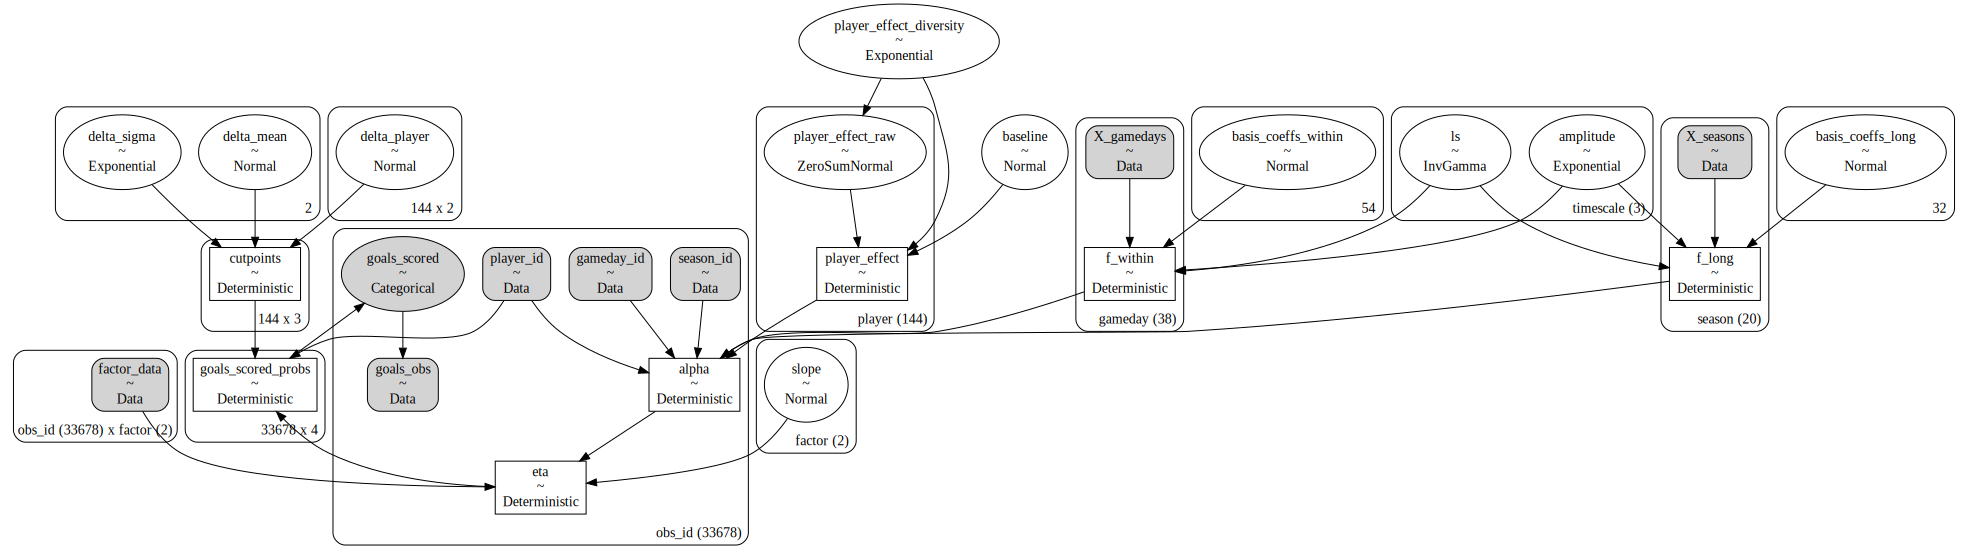

In [31]:
pm.model_to_graphviz(SFM_rlp)

## Prior Predictive Sampling

In [32]:
with SFM_rlp:
    idata = pm.sample_prior_predictive()

Sampling: [amplitude, baseline, basis_coeffs_long, basis_coeffs_within, delta_mean, delta_player, delta_sigma, goals_scored, ls, player_effect_diversity, player_effect_raw, slope]


In [33]:
idata.prior = idata.prior.rename({"goals_scored_probs_dim_1": "event"})

f_within_prior = idata.prior["f_within"]
f_long_prior = idata.prior["f_long"]

index = pd.MultiIndex.from_product(
    [unique_seasons, unique_gamedays],
    names=["season_nbr", "gameday"],
)
unique_combinations = pd.DataFrame(index=index).reset_index()

f_long_prior_aligned = f_long_prior.sel(
    season=unique_combinations["season_nbr"].to_numpy()
).rename({"season": "timestamp"})
f_long_prior_aligned["timestamp"] = unique_combinations.index

f_within_prior_aligned = f_within_prior.sel(
    gameday=unique_combinations["gameday"].to_numpy()
).rename({"gameday": "timestamp"})
f_within_prior_aligned["timestamp"] = unique_combinations.index

f_total_prior = f_long_prior_aligned + f_within_prior_aligned

some_draws = rng.choice(f_total_prior.draw, size=20, replace=True)

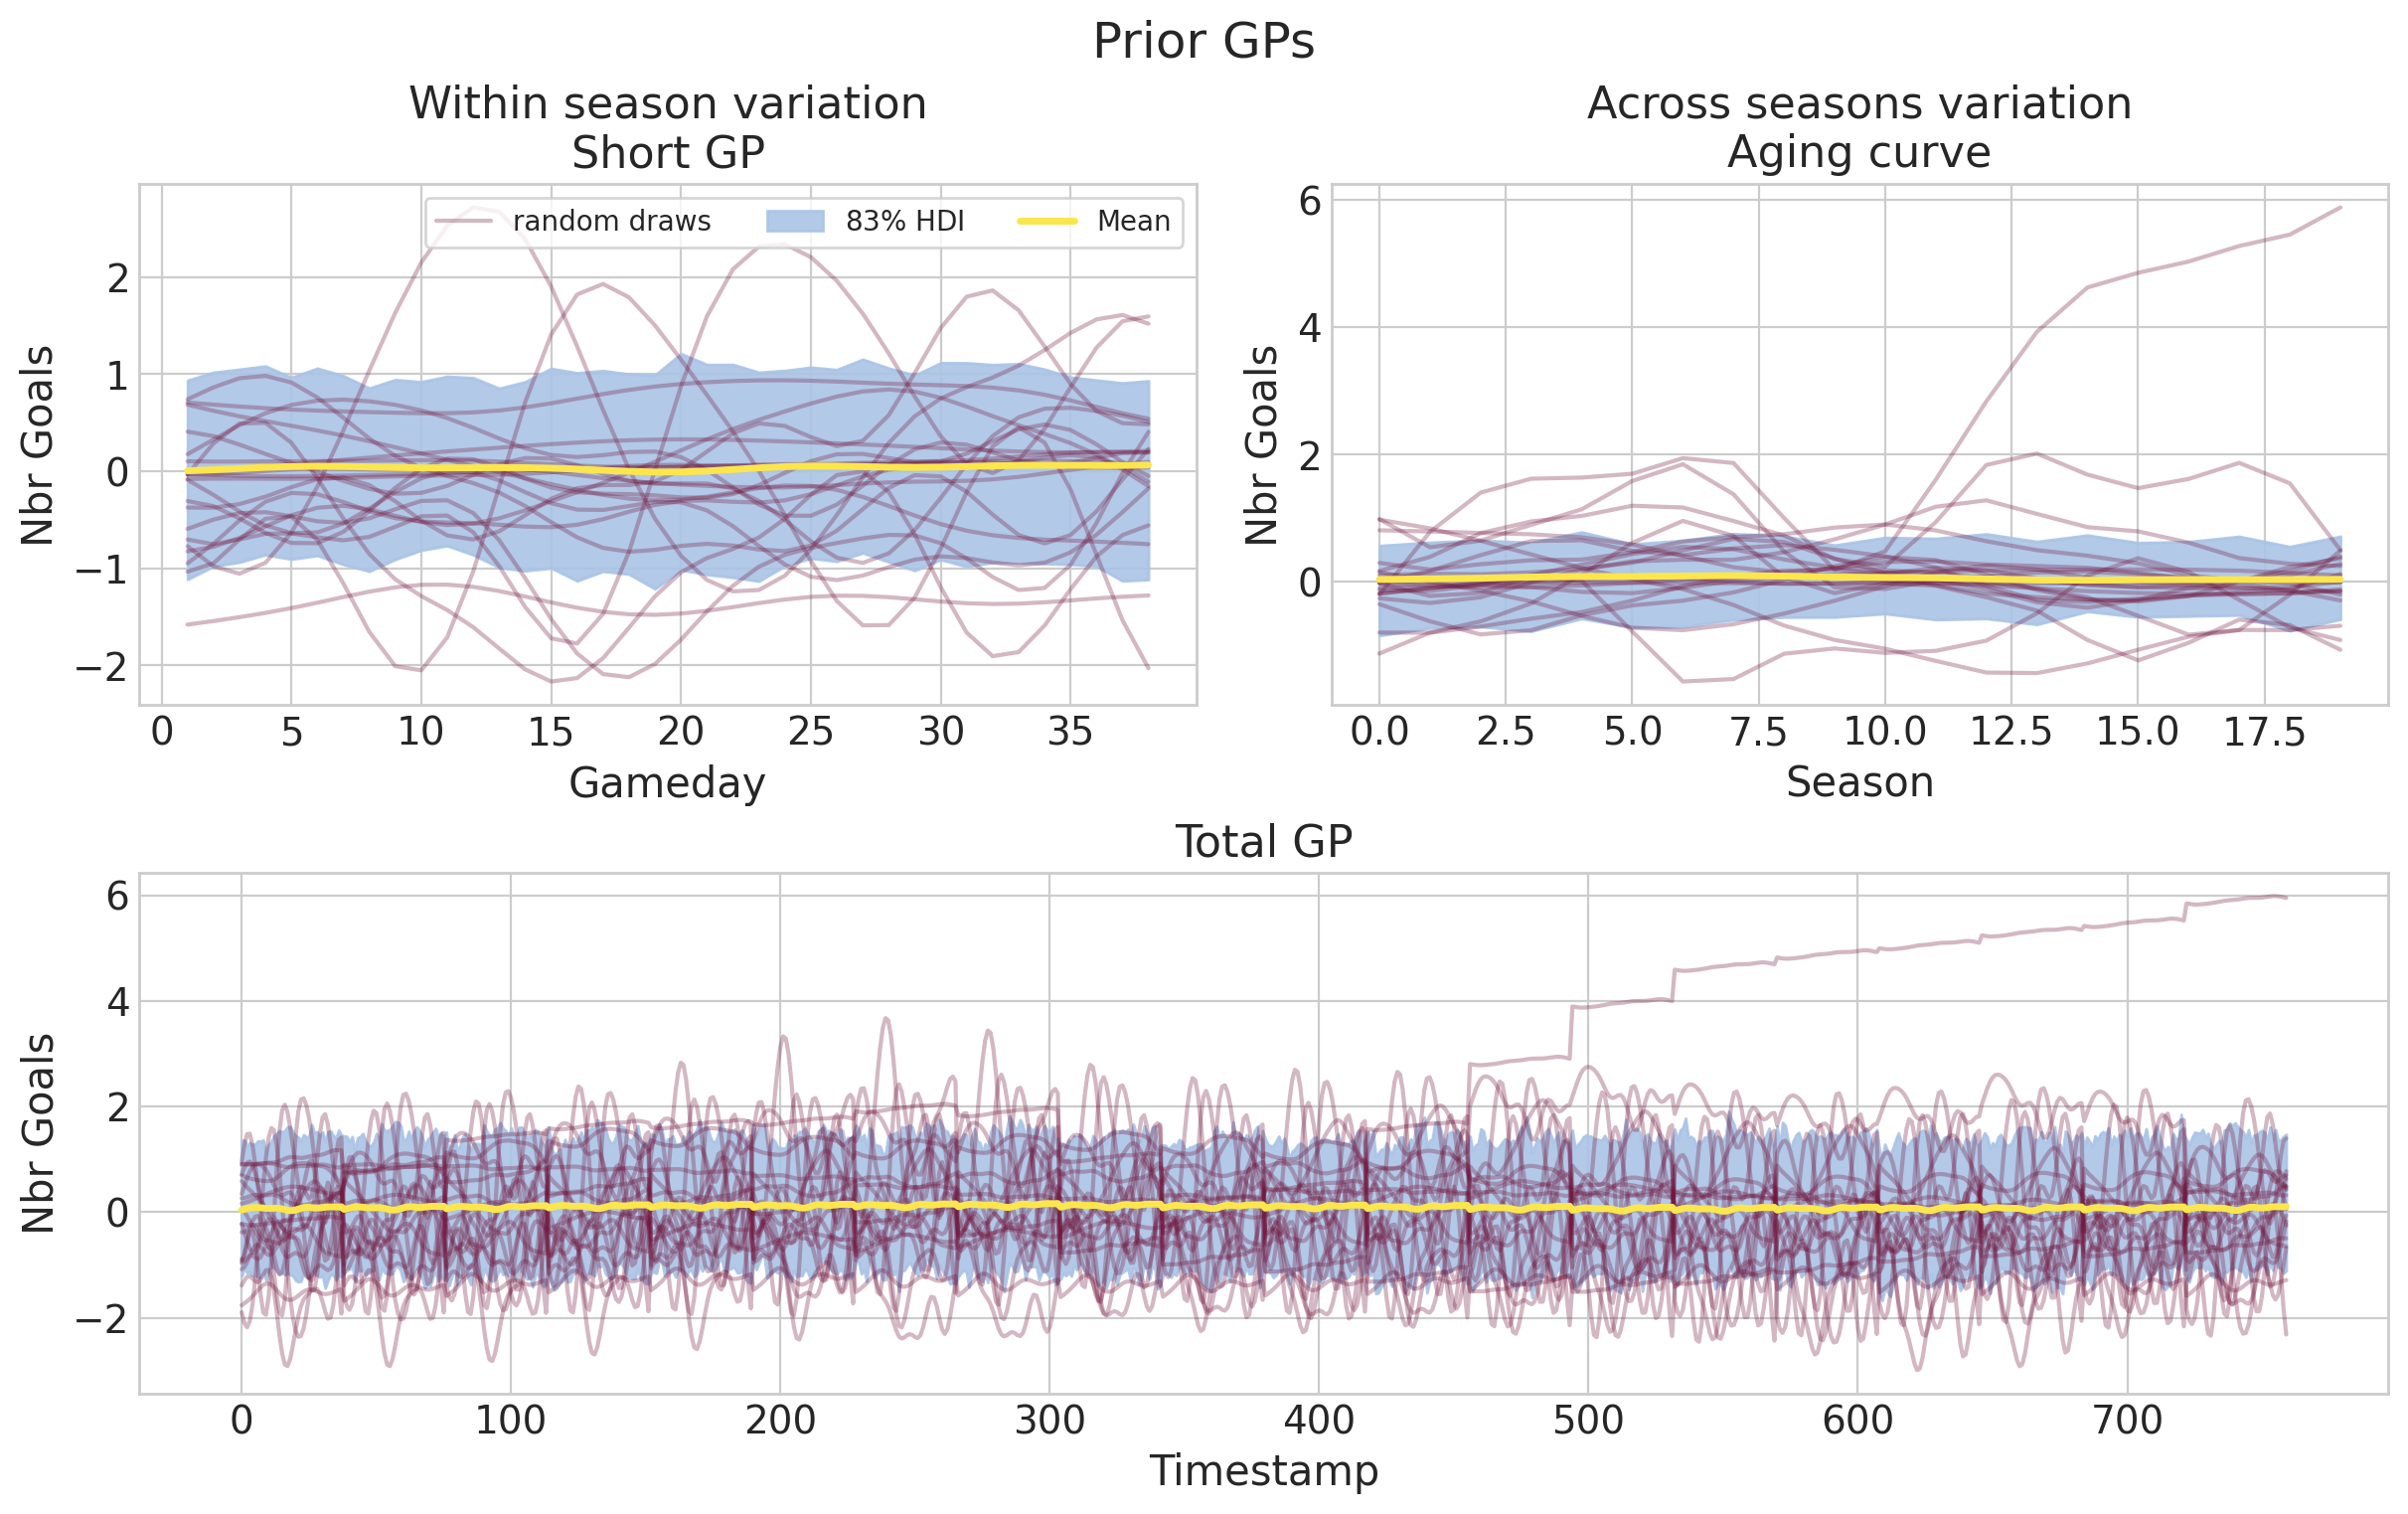

In [34]:
_, axes = plt.subplot_mosaic(
    """
    AB
    CC
    """,
    figsize=(12, 7.5),
    layout="constrained",
)

axes["A"].plot(
    f_within_prior.gameday,
    az.extract(f_within_prior)["f_within"].isel(sample=0),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
    label="random draws",
)
axes["A"].plot(
    f_within_prior.gameday,
    az.extract(f_within_prior)["f_within"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_within_prior.gameday,
    y=f_within_prior,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9, "label": r"$83\%$ HDI"},
    ax=axes["A"],
    smooth=False,
)
axes["A"].plot(
    f_within_prior.gameday,
    f_within_prior.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
    label="Mean",
)
axes["A"].set(
    xlabel="Gameday", ylabel="Nbr Goals", title="Within season variation\nShort GP"
)
axes["A"].legend(fontsize=10, frameon=True, ncols=3)

axes["B"].plot(
    f_long_prior.season,
    az.extract(f_long_prior)["f_long"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_long_prior.season,
    y=f_long_prior,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["B"],
    smooth=False,
)
axes["B"].plot(
    f_long_prior.season,
    f_long_prior.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["B"].set(
    xlabel="Season", ylabel="Nbr Goals", title="Across seasons variation\nAging curve"
)

axes["C"].plot(
    f_total_prior.timestamp,
    az.extract(f_total_prior)["x"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_total_prior.timestamp,
    y=f_total_prior,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["C"],
    smooth=False,
)
axes["C"].plot(
    f_total_prior.timestamp,
    f_total_prior.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["C"].set(xlabel="Timestamp", ylabel="Nbr Goals", title="Total GP")
plt.suptitle("Prior GPs", fontsize=18);

In [35]:
mindex_coords_original = xr.Coordinates.from_pandas_multiindex(
    complete_data.set_index(["name_player", "season", "gameday"]).index,
    "obs_id",
)

idata.prior = idata.prior.assign_coords(mindex_coords_original)
idata.prior_predictive = idata.prior_predictive.assign_coords(mindex_coords_original)
idata.observed_data = idata.observed_data.assign_coords(mindex_coords_original)

## Sampling and convergence checks

In [36]:
# --- In the paper we use 4 chains
# --- Just for speed: set it to 1
N_chains = 1

with SFM_rlp:
    idata.extend(pm.sample(nuts_sampler="numpyro", target_accept=0.99, chains=N_chains))

sample: 100%|█| 2000/2000 [23:43<00:00,  1.40it/s, 255 steps of size 1.64e-02. a
/opt/anaconda3/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py:1011: UserWarning: Some donated buffers were not usable: ShapedArray(float64[1,1000,143]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
Only one chain was sampled, this makes it impossible to run some convergence checks


In [37]:
with SFM_rlp:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [goals_scored]


Output()

In [38]:
idata.prior = idata.prior.reset_index("obs_id")
idata.prior_predictive = idata.prior_predictive.reset_index("obs_id")
idata.observed_data = idata.observed_data.reset_index("obs_id")

In [39]:
# --- THIS BLOWS MY STORAGE ... around 7GB
#az.to_netcdf(idata, "idata_complete.nc")

In [40]:
if 1==2:
    idata.sample_stats.acceptance_rate.mean().data.round(2)

In [41]:
if 1==2:
    idata.sample_stats.diverging.sum().data

In [42]:
#az.ess(idata).min().to_pandas().sort_values().round()

In [43]:
if 1==2:
    az.summary(
        idata,
        var_names=[
            "amplitude",
            "baseline",
            "player_effect_diversity",
            "ls",
            "slope",
            "delta_sigma",
            "delta_mean",
        ],
        round_to=2,
    )

In [44]:
if 1==2:
    az.ess(
        idata,
        var_names=["basis_coeffs_long", "basis_coeffs_within"],
    ).min().to_pandas().round(2)

In [45]:
if 1==2:
    az.rhat(
        idata,
        var_names=["basis_coeffs_long", "basis_coeffs_within"],
    ).max().to_pandas().round(2)

In [46]:
if 1==2:
    az.plot_trace(
        idata,
        var_names=["~alpha", "~goals_scored_probs", "~eta", "~_raw", "~hsgp_coeffs"],
        filter_vars="regex",
    );

## Posterior parameters

In [47]:
if 1==2:
    _, axes = plt.subplot_mosaic(
        """
        AB
        """,
        figsize=(12, 3),
        layout="constrained",
    )
    
    az.plot_forest(
        [idata.prior, idata.posterior],
        model_names=["Prior", "Posterior"],
        var_names=["slope"],
        combined=True,
        ax=axes["A"],
    )
    axes["A"].axvline(c="grey", ls="--")
    axes["A"].set(title="Slopes")
    
    az.plot_forest(
        idata,
        var_names=["slope"],
        combined=True,
        ax=axes["B"],
    )
    axes["B"].axvline(c="grey", ls="--")
    axes["B"].set(title="Posterior only");

In [48]:
if 1==2:
    _, axes = plt.subplot_mosaic(
        """
        AB
        """,
        figsize=(12, 4),
        layout="constrained",
    )
    
    az.plot_forest(
        [idata.prior, idata.posterior],
        model_names=["Prior", "Posterior"],
        var_names=["diversity", "amplitude", "sd_", "_sigma"],
        combined=True,
        filter_vars="regex",
        ax=axes["A"],
    )
    axes["A"].set(title="Standard deviations")
    
    az.plot_forest(
        idata,
        var_names=["diversity", "amplitude", "sd_", "_sigma"],
        combined=True,
        filter_vars="regex",
        ax=axes["B"],
    )
    axes["B"].set(title="Posterior only");

In [49]:
if 1==2:
    _, axes = plt.subplot_mosaic(
        """
        AB
        """,
        figsize=(12, 35),
        layout="constrained",
    )
    
    az.plot_forest(
        [idata.prior, idata.posterior],
        model_names=["Prior", "Posterior"],
        var_names="player_effect",
        combined=True,
        ax=axes["A"],
    )
    axes["A"].axvline(x=idata.posterior.player_effect.mean(), c="grey", ls="--")
    axes["A"].set(title="Player effects")
    
    az.plot_forest(
        idata,
        var_names="player_effect",
        combined=True,
        ax=axes["B"],
    )
    axes["B"].axvline(x=idata.posterior.player_effect.mean(), c="grey", ls="--")
    axes["B"].set(title="Posterior only");

In [50]:
if 1==2:
    ax = az.plot_forest(
        [idata.prior, idata.posterior],
        model_names=["Prior", "Posterior"],
        var_names="ls",
        combined=True,
        figsize=(10, 3),
    )
    ax[0].set(title="GPs lengthscales");

In [51]:
if 1==2:
    _, axes = plt.subplot_mosaic(
        """
        AB
        """,
        figsize=(12, 70),
        layout="constrained",
    )
    az.plot_forest(
        [idata.prior["cutpoints"], idata.posterior["cutpoints"]],
        combined=True,
        model_names=["Prior", "Posterior"],
        ax=axes["A"],
    )
    axes["A"].set(title="Cutpoints")
    az.plot_forest(
        idata,
        var_names=["cutpoints"],
        combined=True,
        ax=axes["B"],
    )
    axes["B"].set(title="Posterior only");

In [52]:
if 1==2:
    az.plot_forest(
        [idata.prior["eta"], idata.posterior["eta"]],
        combine_dims={"chain", "draw", "obs_id"},
        combined=True,
        model_names=["Prior", "Posterior"],
        figsize=(10, 3),
    );

## Performance evolution through time

In [53]:
f_long_post = idata.posterior["f_long"]
f_within_post = idata.posterior["f_within"]

f_long_post_aligned = f_long_post.sel(
    season=unique_combinations["season_nbr"].to_numpy()
).rename({"season": "timestamp"})
f_long_post_aligned["timestamp"] = unique_combinations.index

f_within_post_aligned = f_within_post.sel(
    gameday=unique_combinations["gameday"].to_numpy()
).rename({"gameday": "timestamp"})
f_within_post_aligned["timestamp"] = unique_combinations.index

f_total_post = f_long_post_aligned + f_within_post_aligned

some_draws = rng.choice(int(N_chains*1000), size=20, replace=True)

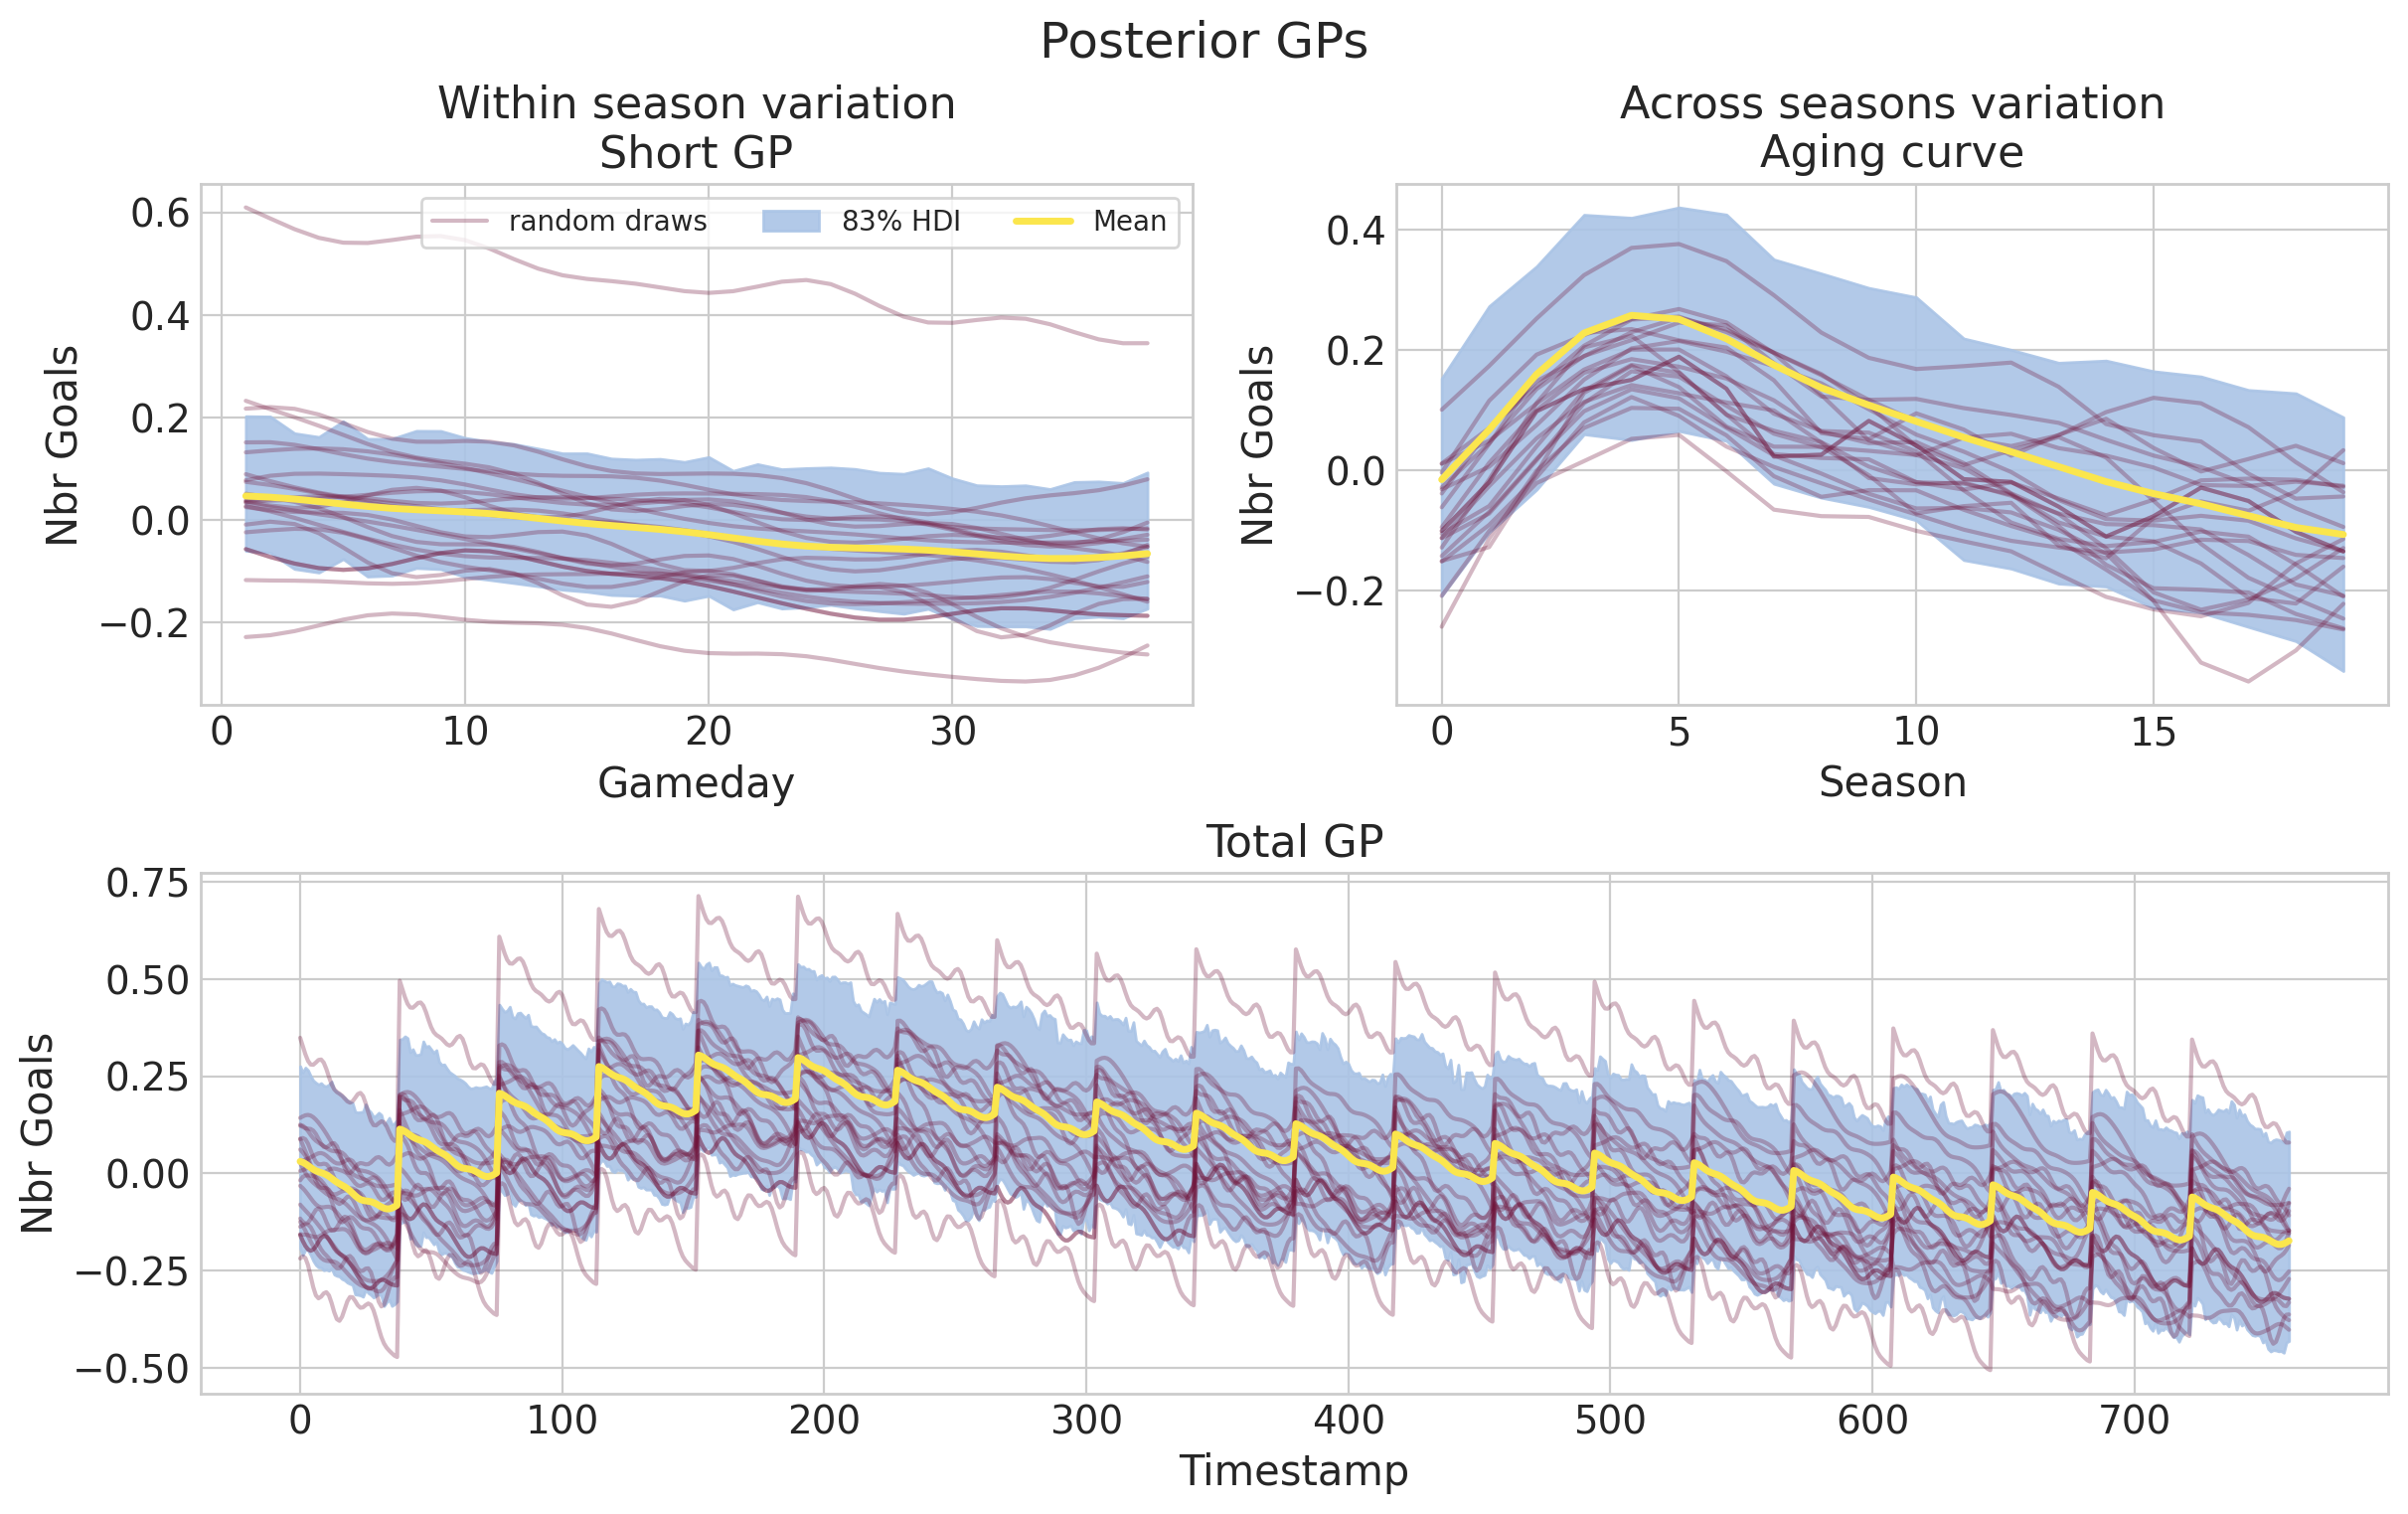

In [54]:
_, axes = plt.subplot_mosaic(
    """
    AB
    CC
    """,
    figsize=(12, 7.5),
    layout="constrained",
)

axes["A"].plot(
    f_within_post.gameday,
    az.extract(f_within_post)["f_within"].isel(sample=0),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
    label="random draws",
)
axes["A"].plot(
    f_within_post.gameday,
    az.extract(f_within_post)["f_within"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_within_post.gameday,
    y=f_within_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9, "label": r"$83\%$ HDI"},
    ax=axes["A"],
    smooth=False,
)
axes["A"].plot(
    f_within_post.gameday,
    f_within_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
    label="Mean",
)
axes["A"].set(
    xlabel="Gameday", ylabel="Nbr Goals", title="Within season variation\nShort GP"
)
axes["A"].legend(fontsize=10, frameon=True, ncols=3)

axes["B"].plot(
    f_long_post.season,
    az.extract(f_long_post)["f_long"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_long_post.season,
    y=f_long_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["B"],
    smooth=False,
)
axes["B"].plot(
    f_long_post.season,
    f_long_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["B"].set(
    xlabel="Season", ylabel="Nbr Goals", title="Across seasons variation\nAging curve"
)

axes["C"].plot(
    f_total_post.timestamp,
    az.extract(f_total_post)["x"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_total_post.timestamp,
    y=f_total_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["C"],
    smooth=False,
)
axes["C"].plot(
    f_total_post.timestamp,
    f_total_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["C"].set(xlabel="Timestamp", ylabel="Nbr Goals", title="Total GP")
plt.suptitle("Posterior GPs", fontsize=18);

[Text(0.5, 0, 'Timestamp'), Text(0, 0.5, 'Nbr Goals'), Text(0.5, 1.0, '')]

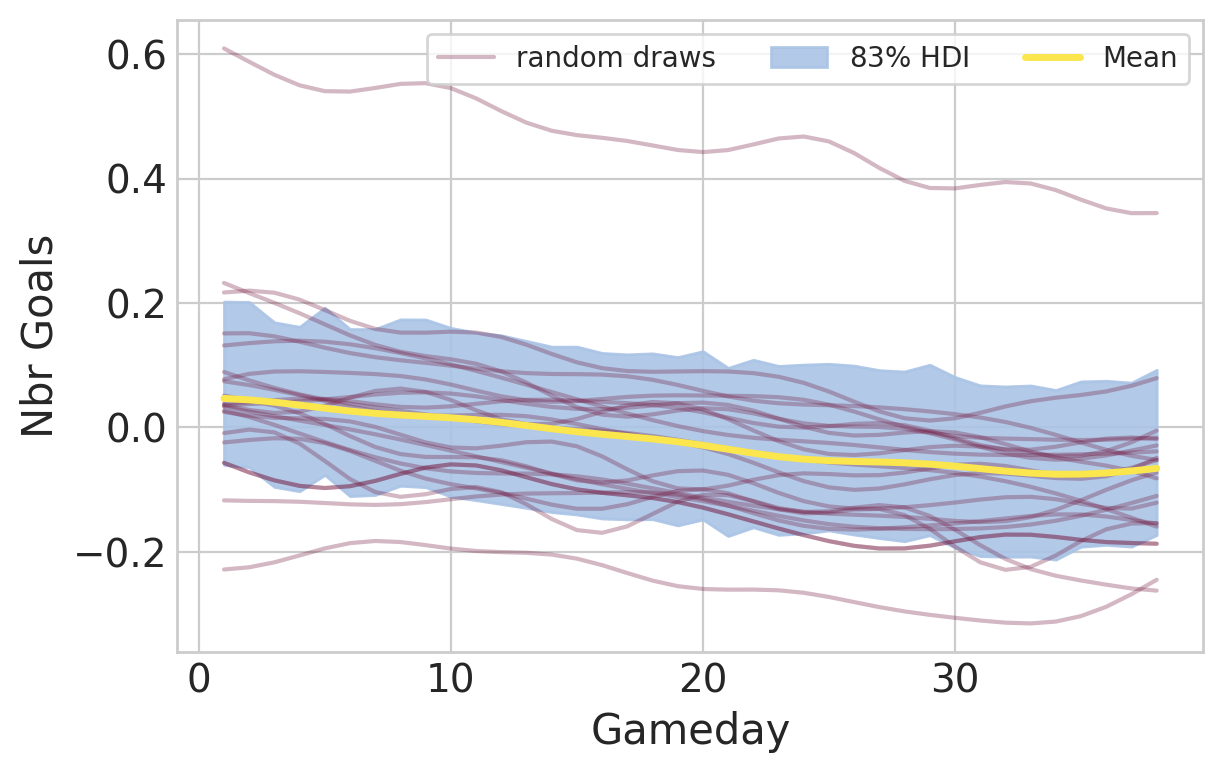

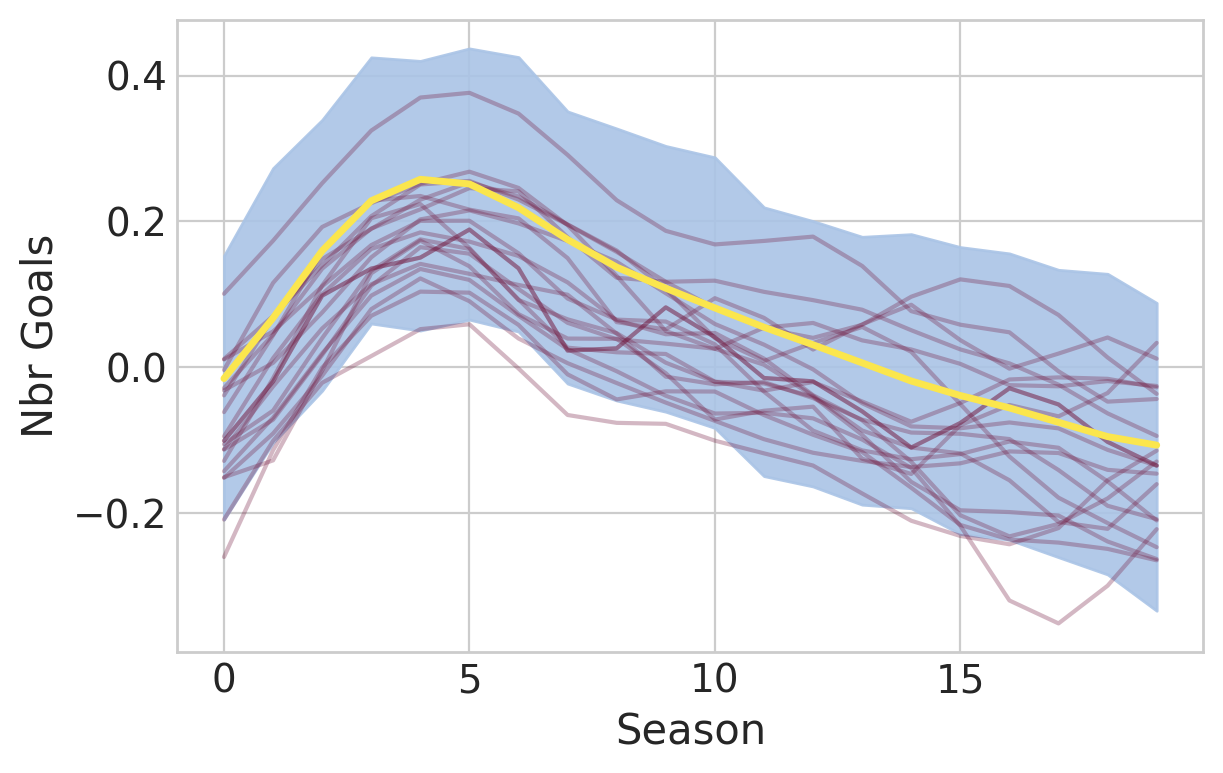

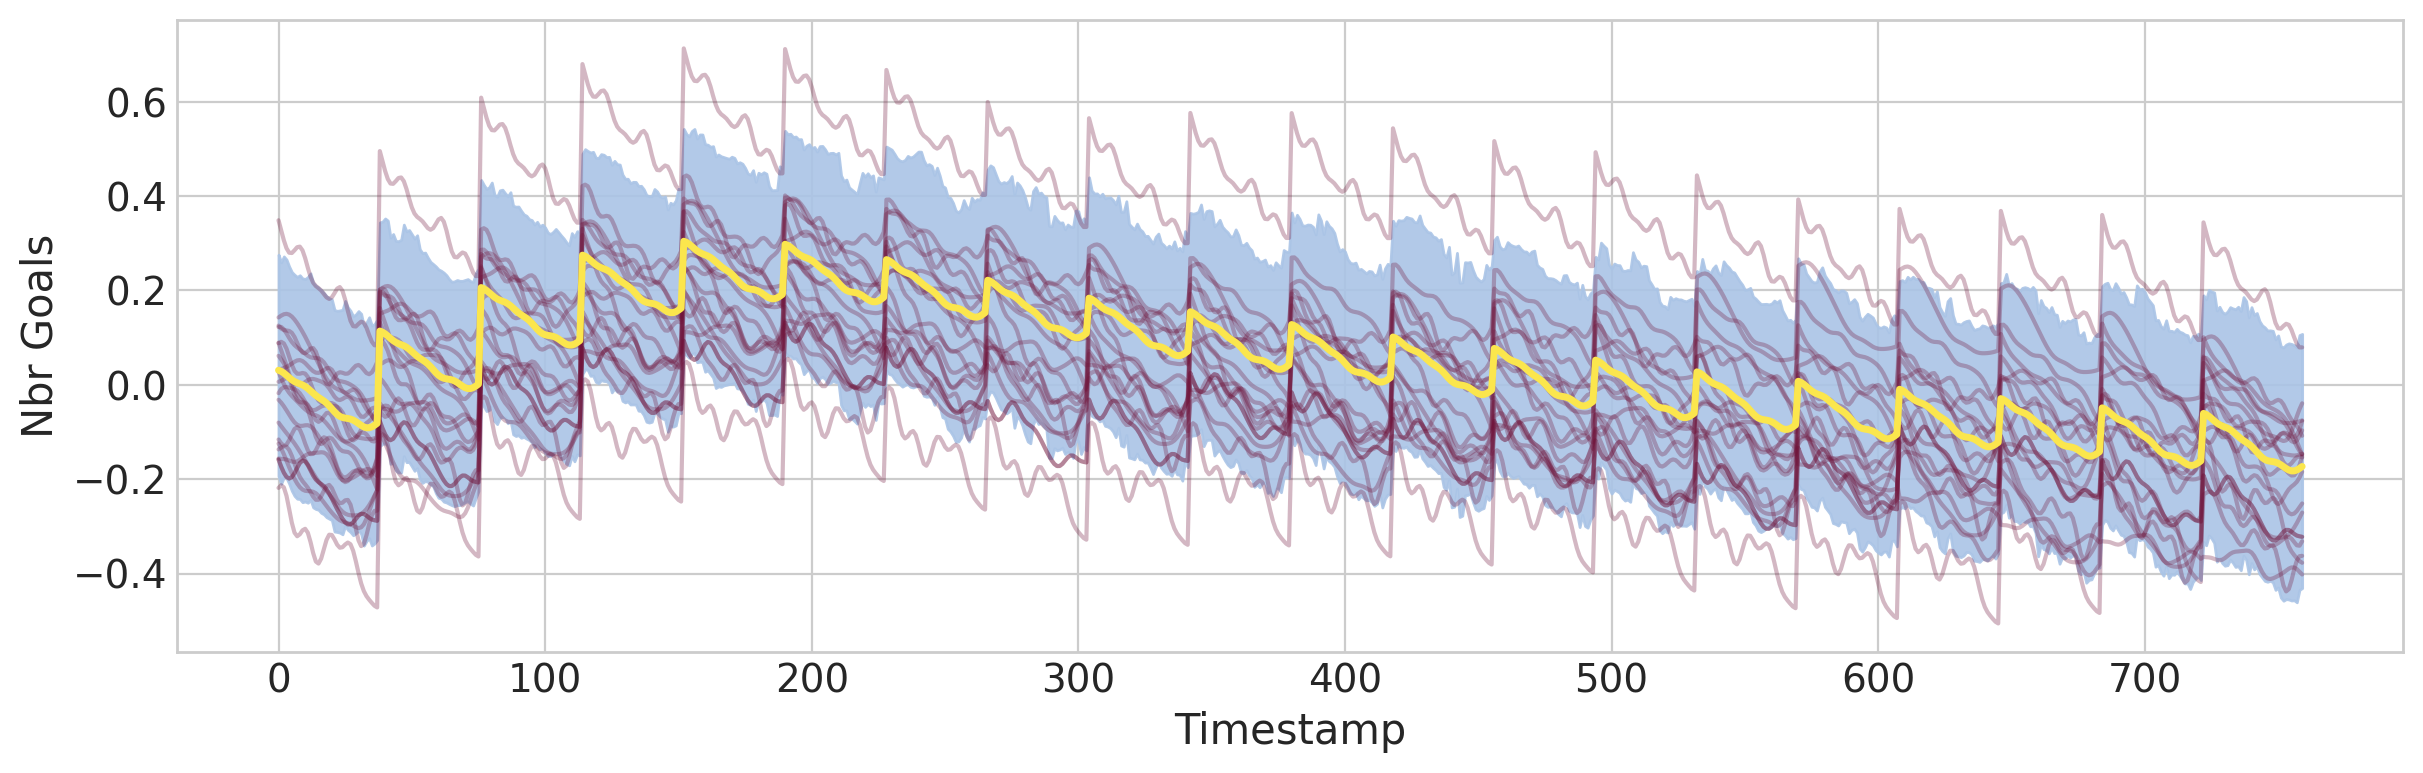

In [55]:
figA, axes = plt.subplot_mosaic(
    """
    A
    """,
    figsize=(6, 3.75),
    layout="constrained",
)

axes["A"].plot(
    f_within_post.gameday,
    az.extract(f_within_post)["f_within"].isel(sample=0),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
    label="random draws",
)
axes["A"].plot(
    f_within_post.gameday,
    az.extract(f_within_post)["f_within"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_within_post.gameday,
    y=f_within_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9, "label": r"$83\%$ HDI"},
    ax=axes["A"],
    smooth=False,
)
axes["A"].plot(
    f_within_post.gameday,
    f_within_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
    label="Mean",
)
axes["A"].set(
    xlabel="Gameday", ylabel="Nbr Goals", title=""
)
axes["A"].legend(fontsize=10, frameon=True, ncols=3, loc='upper right')



figB, axes = plt.subplot_mosaic(
    """
    B
    """,
    figsize=(6, 3.75),
    layout="constrained",
)

axes["B"].plot(
    f_long_post.season,
    az.extract(f_long_post)["f_long"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_long_post.season,
    y=f_long_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["B"],
    smooth=False,
)
axes["B"].plot(
    f_long_post.season,
    f_long_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["B"].set(
    xlabel="Season", ylabel="Nbr Goals", title=""
)


figC, axes = plt.subplot_mosaic(
    """
    C
    """,
    figsize=(12, 3.75),
    layout="constrained",
)

axes["C"].plot(
    f_total_post.timestamp,
    az.extract(f_total_post)["x"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_total_post.timestamp,
    y=f_total_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["C"],
    smooth=False,
)
axes["C"].plot(
    f_total_post.timestamp,
    f_total_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["C"].set(xlabel="Timestamp", ylabel="Nbr Goals", title="")
#plt.suptitle("Posterior GPs", fontsize=18);

In [56]:
if 1==2:
    figA.savefig('../20_figures/HSGPs_within.png')
    figB.savefig('../20_figures/HSGPs_across.png')
    figC.savefig('../20_figures/HSGPs_total.png')

## PAR Analysis

### From posterior samples

In [57]:
with SFM_rlp:
    idata.extend(
        pm.sample_posterior_predictive(idata, compile_kwargs={"mode": "NUMBA"})
    )

Sampling: [goals_scored]


Output()

In [58]:
idata.posterior = idata.posterior.assign_coords(mindex_coords_original)
idata.posterior_predictive = idata.posterior_predictive.assign_coords(
    mindex_coords_original
)
idata.observed_data = idata.observed_data.assign_coords(mindex_coords_original)

idata.posterior = idata.posterior.rename({"goals_scored_probs_dim_1": "event"})

In [59]:
ELITE_LEVEL = [
    "alan-shearer",
    "adriano",
    "alessandro-del-piero",
    "andriy-shevchenko",
    "antoine-griezmann",
    "antonio-di-natale",
    "arjen-robben",
    "carlos-vela",
    "chicharito",
    "christian-vieri",
    "ciro-immobile",
    "cristiano-ronaldo",
    "david-villa",
    "didier-drogba",
    "diego-costa",
    "diego-forlan",
    "dimitar-berbatov",
    "dries-mertens",
    "eden-hazard",
    "edinson-cavani",
    "erling-haaland",
    "fabio-quagliarella",
    "fernando-torres",
    "filippo-inzaghi",
    "gareth-bale",
    "gonzalo-higuain",
    "harry-kane",
    "henrik-larsson",
    "heung-min-son",
    "iago-aspas",
    "jamie-vardy",
    "jermain-defoe",
    "karim-benzema",
    "klaas-jan-huntelaar",
    "lionel-messi",
    "lorenzo-insigne",
    "luca-toni",
    "luis-suarez-2",
    "mario-gomez",
    "mario-mandzukic",
    "michael-owen",
    "miroslav-klose",
    "mohamed-salah",
    "neymar",
    "olivier-giroud",
    "paulo-dybala",
    "pierre-emerick-aubameyang",
    "raul",
    "robert-lewandowski",
    "roberto-firmino",
    "robin-van-persie",
    "romelu-lukaku",
    "ronaldinho",
    "ronaldo",
    "ruud-van-nistelrooy",
    "samuel-etoo",
    "sergio-aguero",
    "thierry-henry",
    "wayne-rooney",
    "zlatan-ibrahimovic",
]
REPLACEMENT_LEVEL = [
    "adam-szalai",
    "adrian-lopez",
    "ailton",
    "alberto-gilardino",
    "alberto-paloschi",
    "alexander-zickler",
    "alvaro-morata",
    "andre-silva",
    "aritz-aduriz",
    "arkadiusz-milik",
    "bafetimbi-gomis",
    "bobby-zamora",
    "carlos-bacca",
    "carsten-jancker",
    "christian-benteke",
    "clint-dempsey",
    "craig-bellamy",
    "david-nugent",
    "diego-milito",
    "ebbe-sand",
    "emanuele-giaccherini",
    "emile-heskey",
    "emile-mpenza",
    "eric-maxim-choupo-moting",
    "fernando-llorente",
    "giampaolo-pazzini",
    "giovane-elber",
    "giovani-dos-santos",
    "graziano-pelle",
    "hatem-ben-arfa",
    "helder-postiga",
    "hugo-almeida",
    "inaki-williams",
    "ivica-olic",
    "jackson",
    "jimmy-briand",
    "joao-felix",
    "johan-elmander",
    "john-carew",
    "john-guidetti",
    "jon-dahl-tomasson",
    "jonathan-soriano",
    "jose-antonio-reyes",
    "joseba-llorente",
    "joselu",
    "jozy-altidore",
    "julian-schieber",
    "kenny-miller",
    "leon-best",
    "lucas-barrios",
    "luis-fabiano",
    "lukas-podolski",
    "manu-del-moral",
    "marco-borriello",
    "marcus-berg",
    "marek-mintal",
    "mauro-icardi",
    "michu",
    "mladen-petric",
    "niclas-fuellkrug",
    "nicolas-anelka",
    "nikola-kalinic",
    "nils-petersen",
    "nolito",
    "oliver-neuville",
    "pato",
    "paulo-sergio",
    "peter-crouch",
    "raul-jimenez",
    "ricardo-quaresma",
    "robbie-keane",
    "robinho",
    "roy-makaay",
    "sergio-garcia",
    "stefan-kiessling",
    "tim-cahill",
    "wissam-ben-yedder",
]

In [60]:
post_preds = idata.posterior_predictive.reset_index("obs_id")
rlp_perf = post_preds["goals_scored"].where(
    post_preds["name_player"].isin(REPLACEMENT_LEVEL), drop=True
)
elite_perf = post_preds["goals_scored"].where(
    post_preds["name_player"].isin(ELITE_LEVEL), drop=True
)
PAR = (
    elite_perf.groupby("name_player").mean("obs_id") - rlp_perf.mean("obs_id")
).rename("PAR")

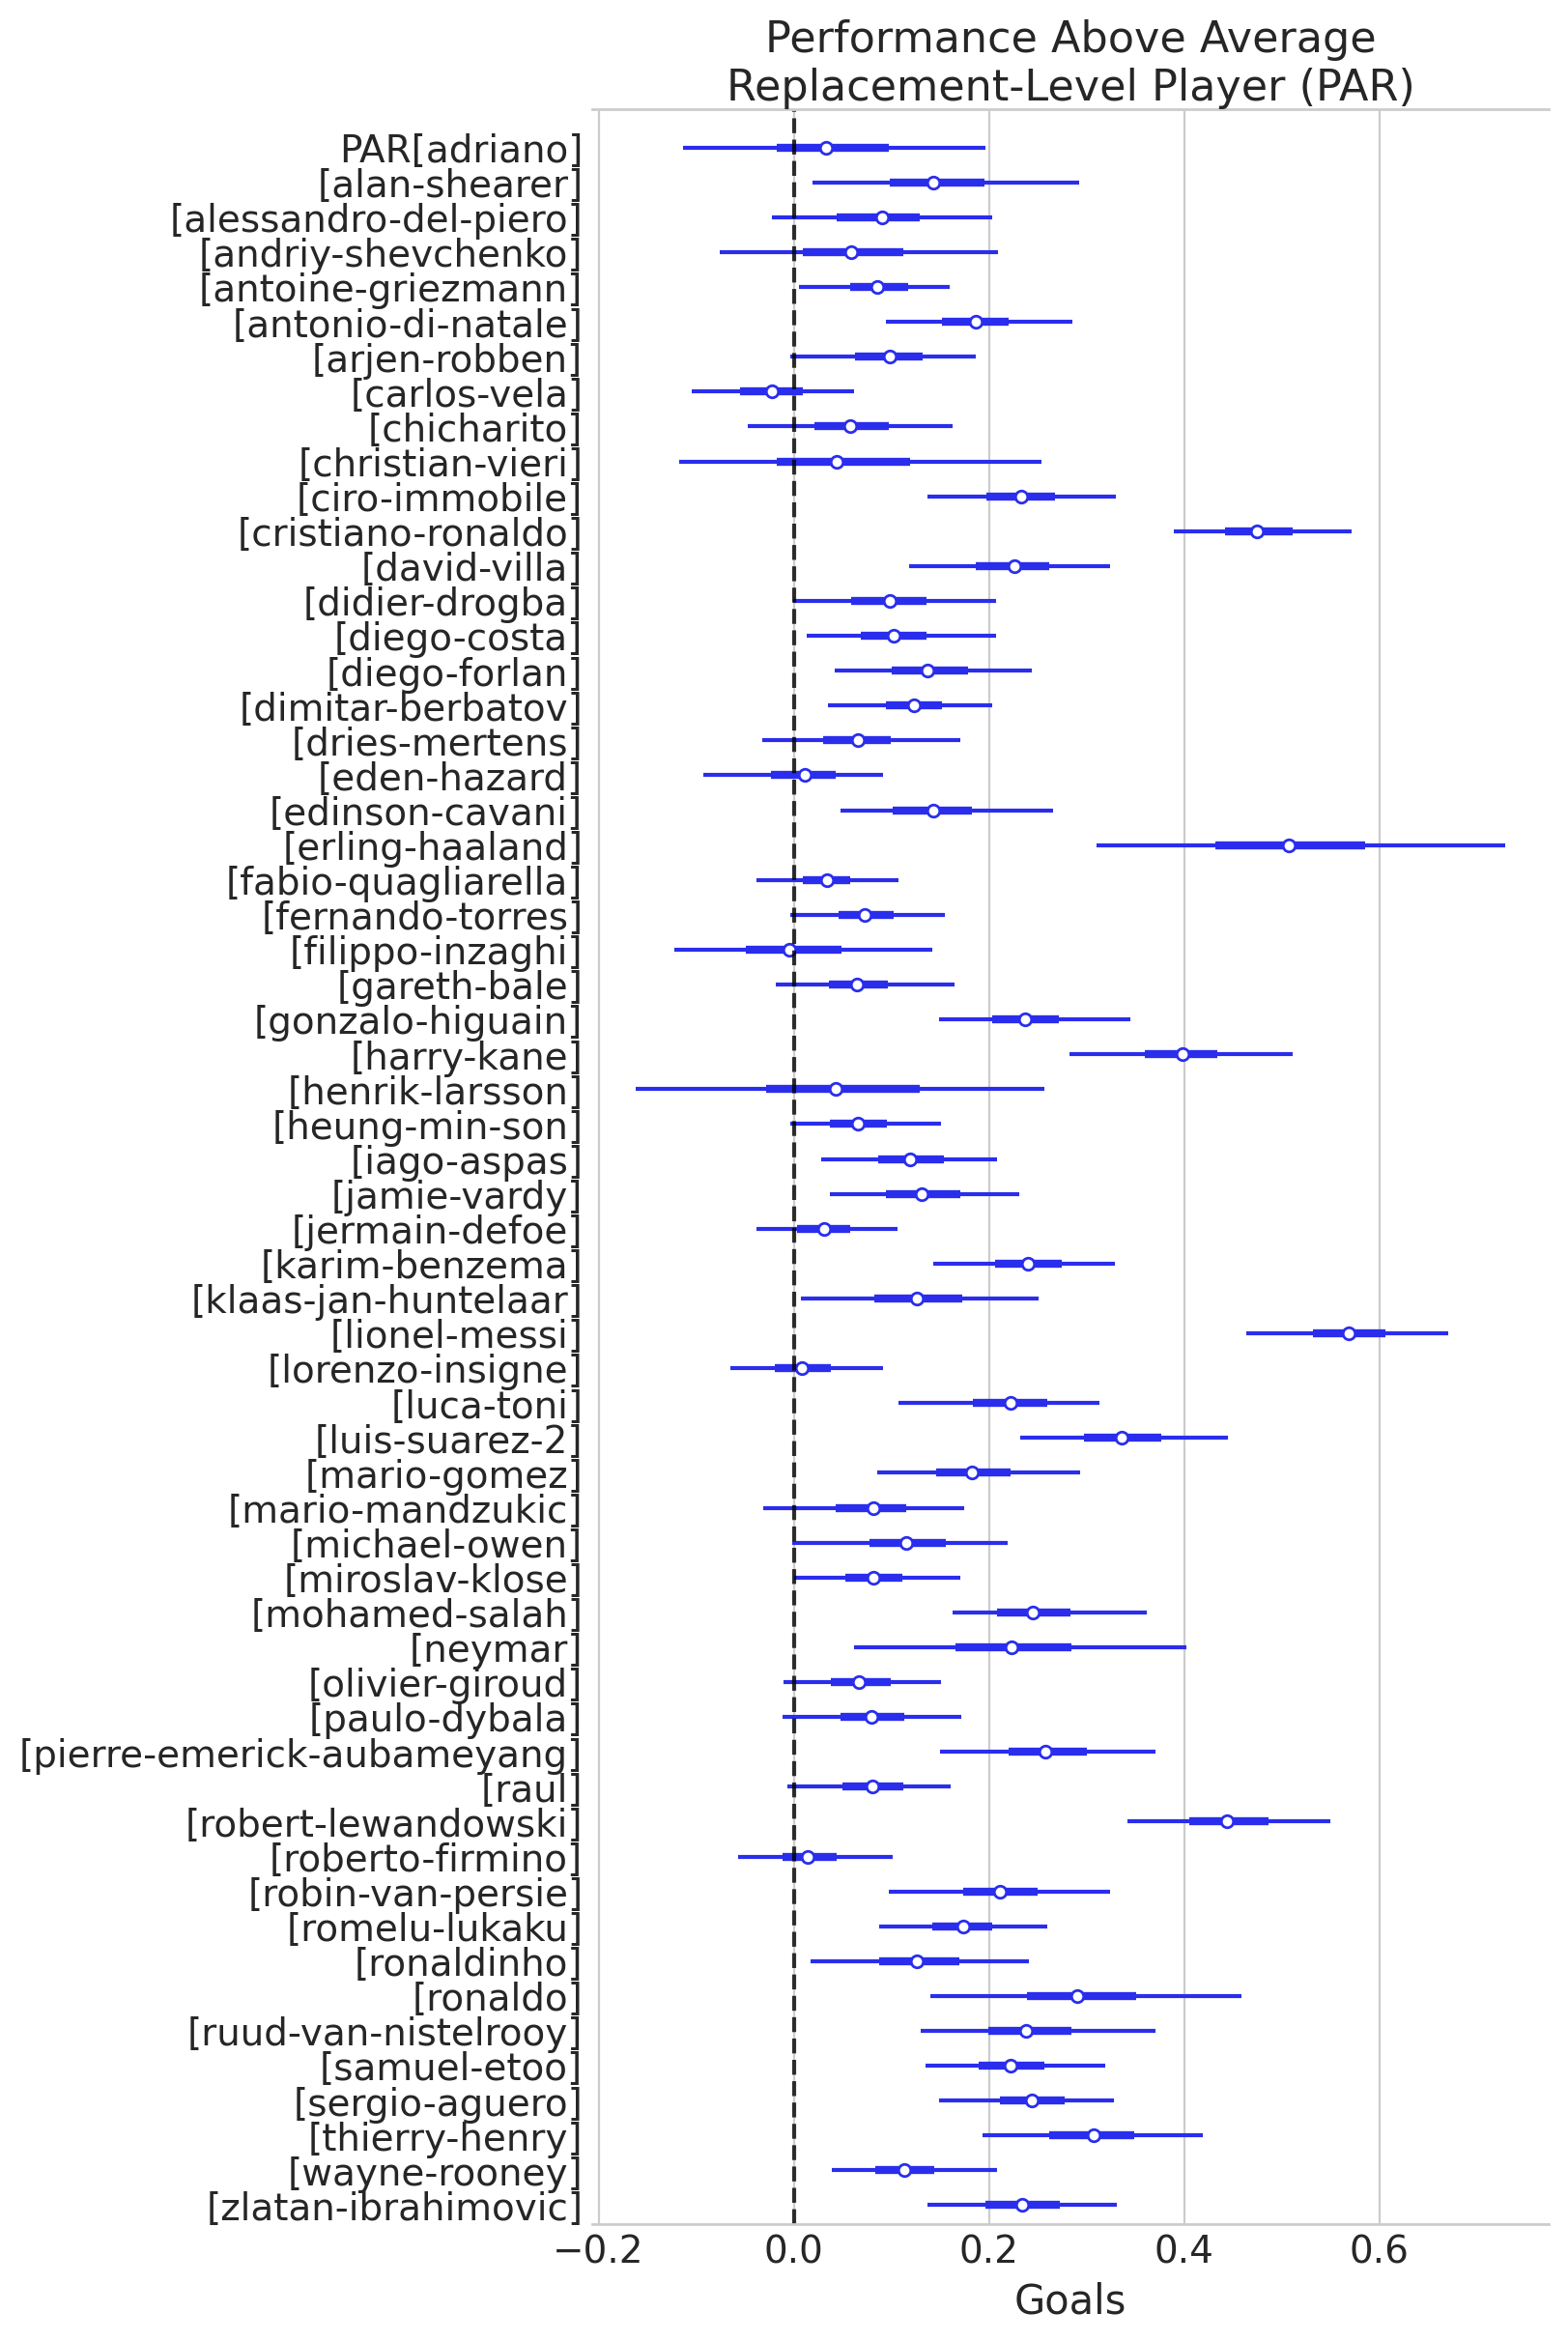

In [61]:
ax = az.plot_forest(PAR, combined=True, figsize=(8, 12))
ax[0].axvline(c="k", ls="--", alpha=0.8)
ax[0].set(
    title="Performance Above Average Replacement-Level Player (PAR)", xlabel="Goals"
);

### From equal teams

In [62]:
with SFM_rlp:
    # all teams are equal
    pm.set_data({"factor_data": np.zeros_like(factors_sdz)})

    counterfact_preds = pm.sample_posterior_predictive(
        idata,
        var_names=["goals_scored"],
        predictions=True,
        compile_kwargs={"mode": "NUMBA"},
    )

Sampling: [goals_scored]


Output()

In [63]:
counterfact_preds.predictions = counterfact_preds.predictions.assign_coords(
    mindex_coords_original
)

preds = counterfact_preds.predictions["goals_scored"].reset_index("obs_id")
rlp_perf = preds.where(preds["name_player"].isin(REPLACEMENT_LEVEL), drop=True)
elite_perf = preds.where(preds["name_player"].isin(ELITE_LEVEL), drop=True)

SAR = (
    elite_perf.groupby("name_player").mean("obs_id") - rlp_perf.mean("obs_id")
).rename("SAR")
diff = SAR - PAR

In [64]:
PLAYER_SUBSET = [
    "alan-shearer",
    "andriy-shevchenko",
    "cristiano-ronaldo",
    "eden-hazard",
    "erling-haaland",
    "falcao",
    "harry-kane",
    "lionel-messi",
    "ronaldinho",
    "ronaldo",
    "thierry-henry",
    "wayne-rooney",
]
SAR_plot = SAR.where(SAR["name_player"].isin(PLAYER_SUBSET), drop=True).rename("")
diff_plot = diff.where(diff["name_player"].isin(PLAYER_SUBSET), drop=True).rename("")

SAR_mean = SAR_plot.mean(("chain", "draw"))

# sort indices based on means in descending order
sorted_indices = np.argsort(-SAR_mean.to_numpy())

# reorder based on sorted indices
sorted_SAR_plot = SAR_plot.isel(name_player=sorted_indices)
sorted_SAR_plot["name_player"] = sorted_SAR_plot.name_player.str.replace(
    "-", " "
).str.title()
sorted_diff_plot = diff_plot.isel(name_player=sorted_indices)
sorted_diff_plot["name_player"] = sorted_diff_plot.name_player.str.replace(
    "-", " "
).str.title()

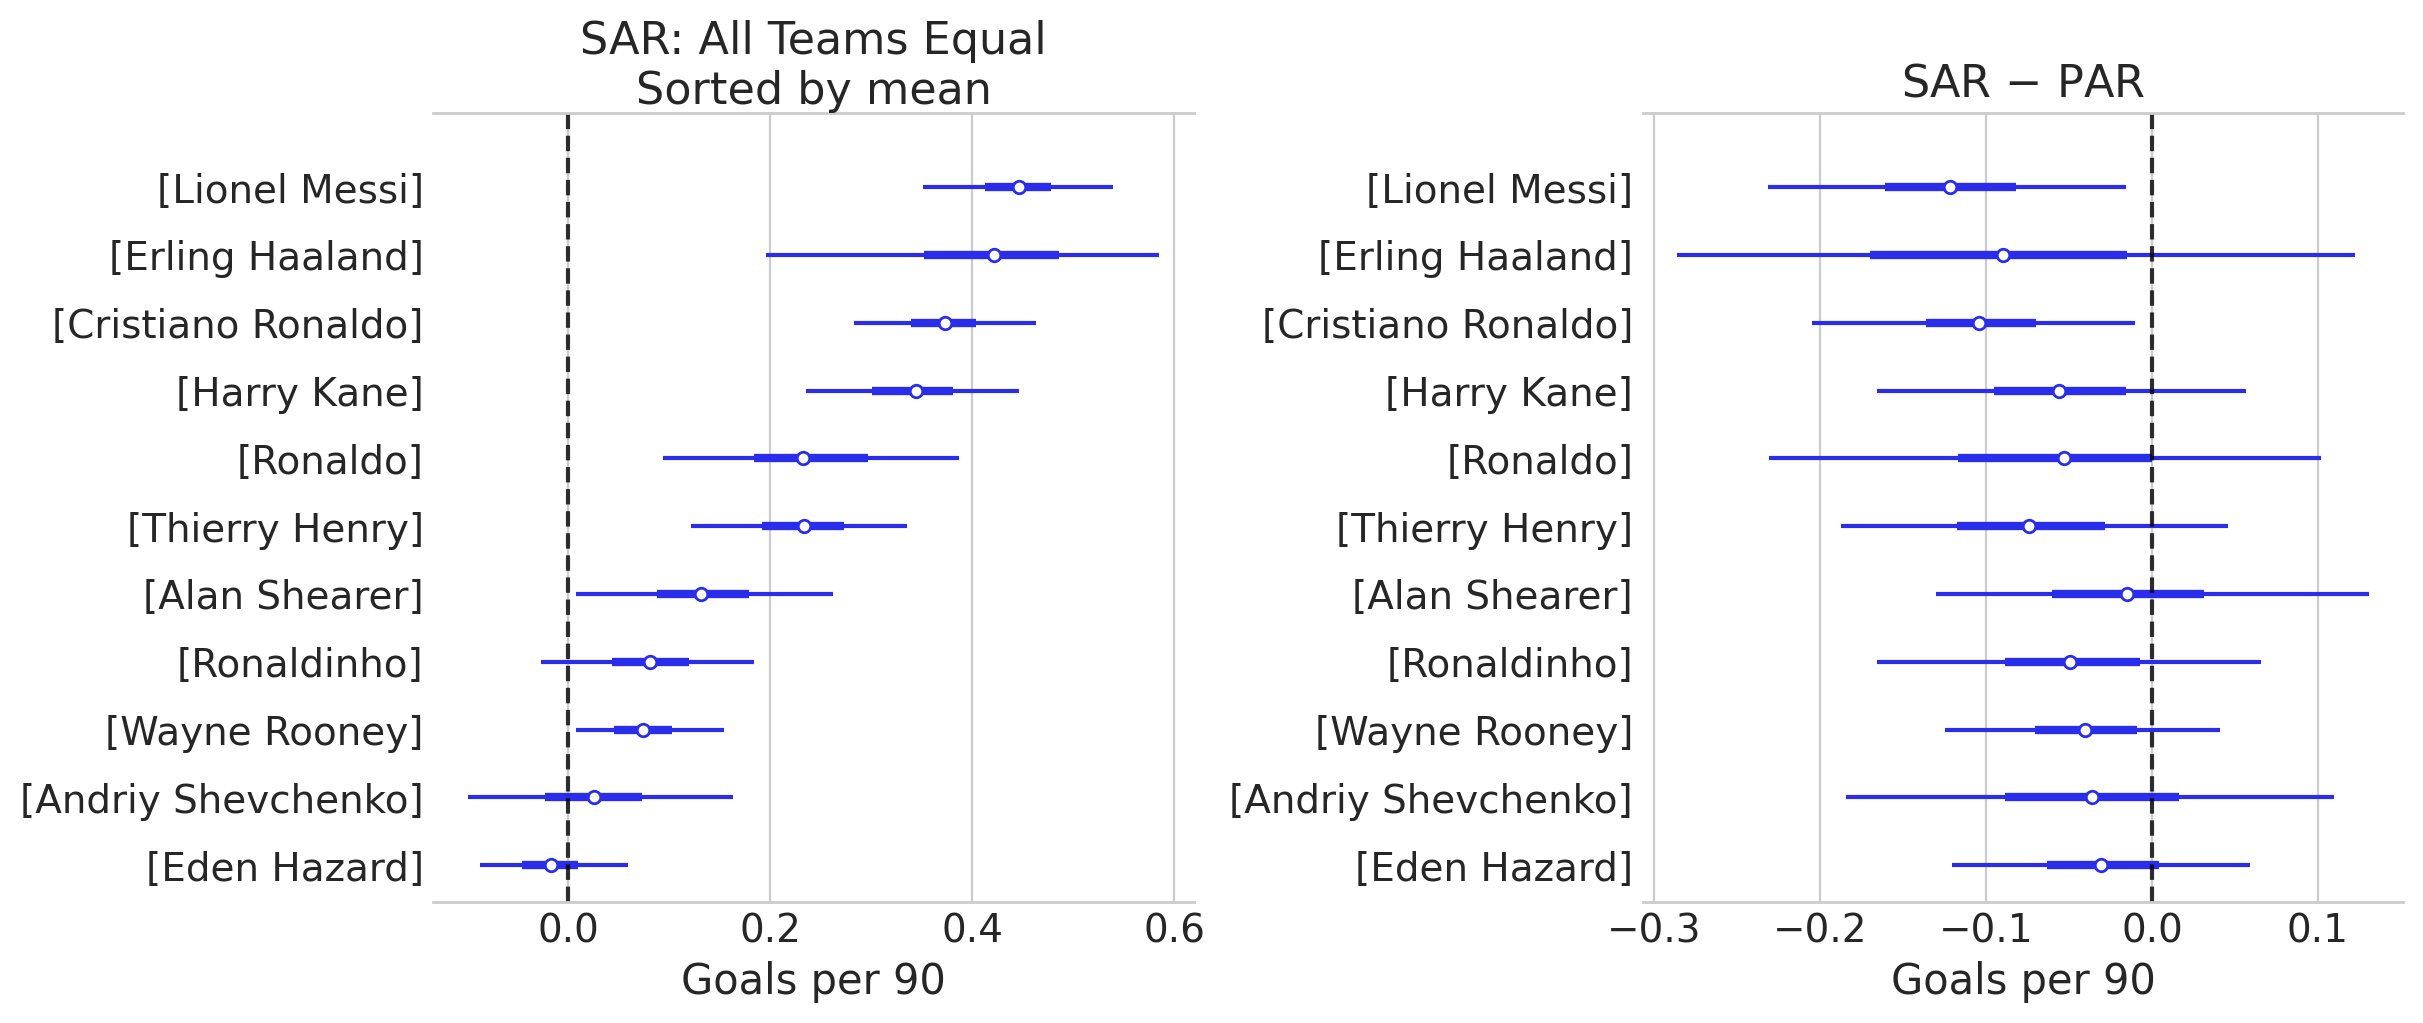

In [65]:
_, (left, right) = plt.subplots(1, 2)

az.plot_forest(sorted_SAR_plot, combined=True, ax=left)
az.plot_forest(sorted_diff_plot, combined=True, ax=right)

left.axvline(c="k", ls="--", alpha=0.8)
left.set(title="SAR: All Teams Equal\nSorted by mean", xlabel="Goals per 90")
right.axvline(c="k", ls="--", alpha=0.8)
right.set(title="SAR $-$ PAR", xlabel="Goals per 90");

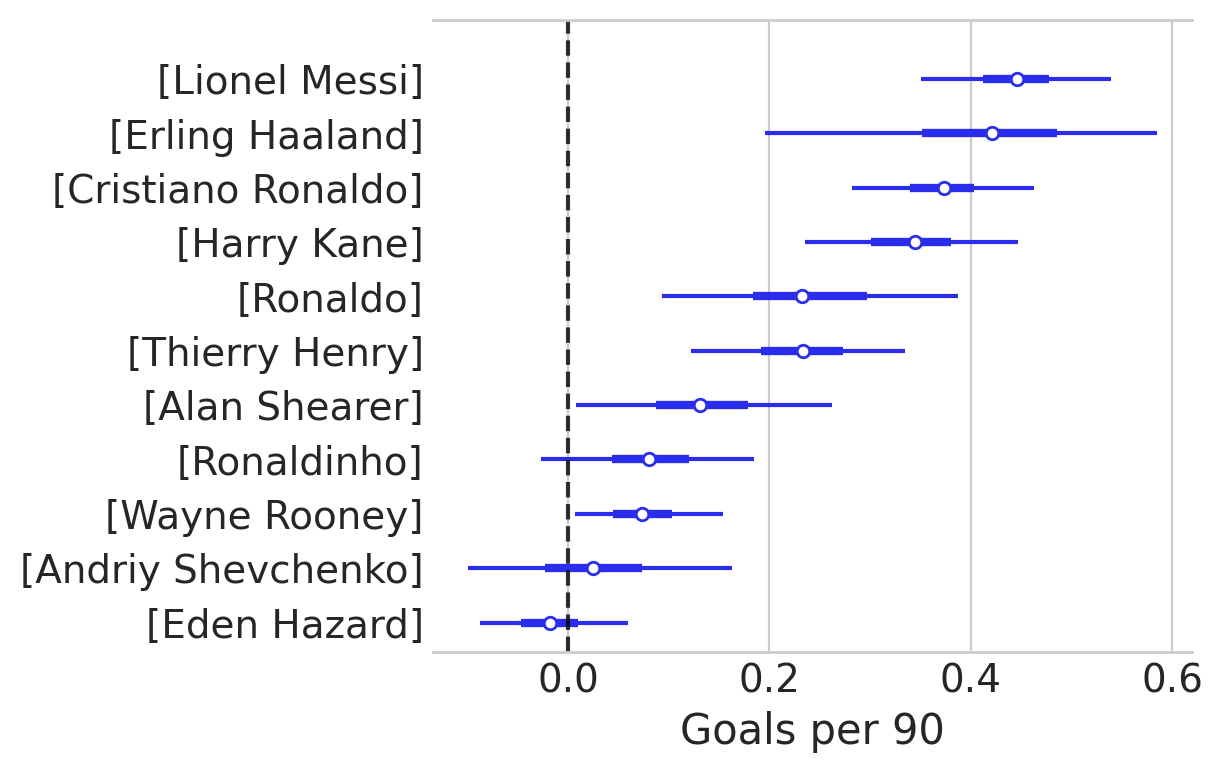

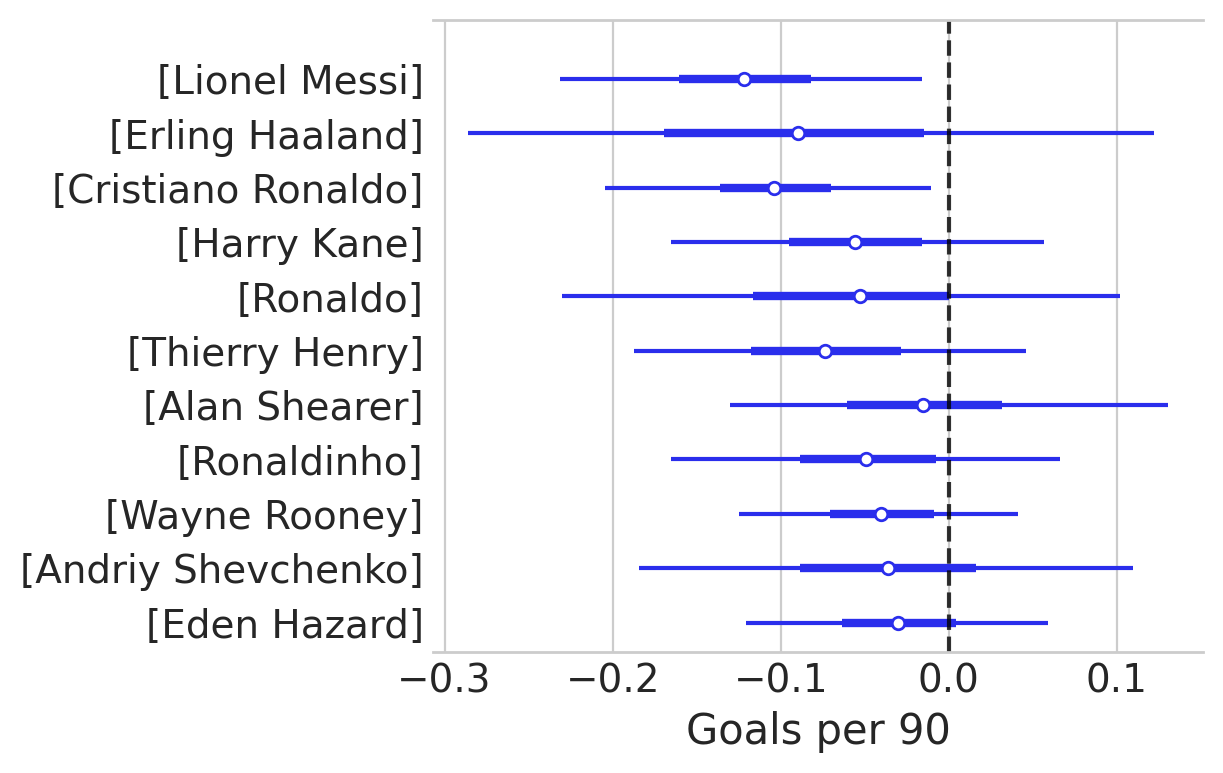

In [66]:
fig_left, left = plt.subplots(1, 1, figsize=(6,3.75))

az.plot_forest(sorted_SAR_plot, combined=True, ax=left)
left.axvline(c="k", ls="--", alpha=0.8)
left.set(title="", xlabel="Goals per 90")



fig_right, right = plt.subplots(1, 1, figsize=(6,3.75))

az.plot_forest(sorted_diff_plot, combined=True, ax=right)
right.axvline(c="k", ls="--", alpha=0.8)
right.set(title="", xlabel="Goals per 90");

In [67]:
if 1==2:
    fig_right.savefig('../20_figures/SAR_right.png')
    fig_left.savefig('../20_figures/SAR_left.png')

## In-Sample Forecast Evaluation

### LOO-CV vs Competitor Models

1. *naive1*: player-specific $\alpha$ + factors
4. *naive4*: player-specific $\alpha$

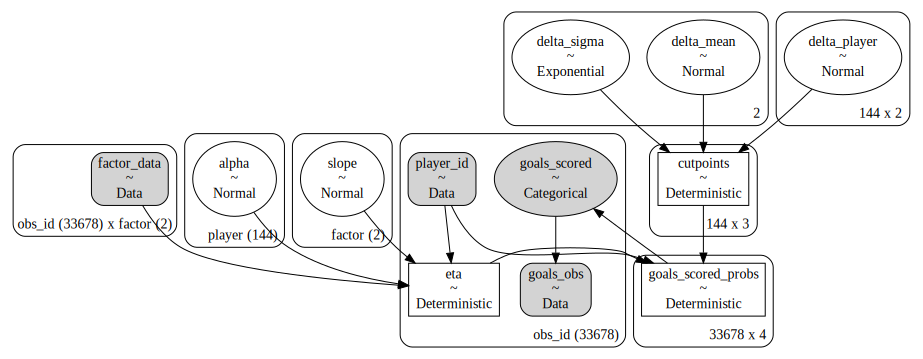

In [68]:
with pm.Model(coords=COORDS) as SFM_naive1:

    # Data containers
    factor_data = pm.Data(
        "factor_data", factors_sdz.to_numpy(), dims=("obs_id", "factor")
    )
    player_id = pm.Data("player_id", player_idx, dims="obs_id")
    goals_obs = pm.Data(
        "goals_obs", complete_data["goals_cats"].to_numpy(), dims="obs_id"
    )


    # ------------------------------------- Alpha ------------------------------------- #
    
    # --- Prior for "alpha"
    alpha = pm.Normal("alpha", sigma=1, dims="player")

    # ------------------------------------- Factor Loadings ------------------------------------- #
    
    # --- Prior for Factor-Coefficients
    slope = pm.Normal("slope", sigma=2.5, dims="factor")

    # ------------------------------------- Cutpoints ------------------------------------- #
    # Hyperpriors for the differences between cutpoints (delta)
    cutpoint_offset = 4
    delta_mean = pm.Normal(
        "delta_mean", mu=delta_prior * cutpoint_offset, sigma=1, shape=2
    )  # Mean of differences across all players
    delta_sigma = pm.Exponential(
        "delta_sigma", 1, shape=2
    )  # Variation of the differences

    # Player-specific differences (delta)
    delta_player = delta_mean + delta_sigma * pm.Normal(
        "delta_player", shape=(len(COORDS["player"]), 2)
    )


    # Cumulative sum to construct cutpoints
    # Ensure differences are positive using softplus
    # dims=("player", "cutpoint")
    cutpoints = pm.Deterministic(
        "cutpoints",
        pt.concatenate(
            [
                pt.full((len(COORDS["player"]), 1), cutpoint_offset),
                pt.cumsum(pt.softplus(delta_player), axis=-1) + cutpoint_offset,
            ],
            axis=-1,
        ),  # Start at cutpoint_offset and sum differences
    )


    # ------------------------------------- Build the Conditional Mean ------------------------------------- #
    eta = pm.Deterministic(
        "eta", alpha[player_id] + pm.math.dot(factor_data, slope), dims="obs_id"
    )

    # likelihood
    pm.OrderedLogistic(
        "goals_scored",
        cutpoints=cutpoints[player_id],
        eta=eta,
        observed=goals_obs,
        dims="obs_id",
    )


pm.model_to_graphviz(SFM_naive1)

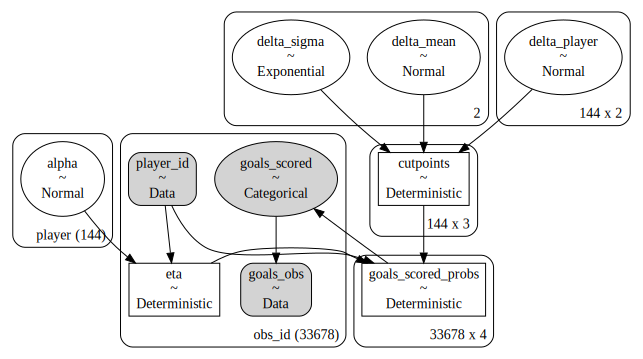

In [69]:
with pm.Model(coords=COORDS) as SFM_naive4:

    # Data containers
    player_id = pm.Data("player_id", player_idx, dims="obs_id")
    goals_obs = pm.Data(
        "goals_obs", complete_data["goals_cats"].to_numpy(), dims="obs_id"
    )


    # ------------------------------------- Alpha ------------------------------------- #
    
    # --- Prior for "alpha"
    alpha = pm.Normal("alpha", sigma=1, dims="player")

    
    # ------------------------------------- Cutpoints ------------------------------------- #
    # Hyperpriors for the differences between cutpoints (delta)
    cutpoint_offset = 4
    delta_mean = pm.Normal(
        "delta_mean", mu=delta_prior * cutpoint_offset, sigma=1, shape=2
    )  # Mean of differences across all players
    delta_sigma = pm.Exponential(
        "delta_sigma", 1, shape=2
    )  # Variation of the differences

    # Player-specific differences (delta)
    delta_player = delta_mean + delta_sigma * pm.Normal(
        "delta_player", shape=(len(COORDS["player"]), 2)
    )


    # Cumulative sum to construct cutpoints
    # Ensure differences are positive using softplus
    # dims=("player", "cutpoint")
    cutpoints = pm.Deterministic(
        "cutpoints",
        pt.concatenate(
            [
                pt.full((len(COORDS["player"]), 1), cutpoint_offset),
                pt.cumsum(pt.softplus(delta_player), axis=-1) + cutpoint_offset,
            ],
            axis=-1,
        ),  # Start at cutpoint_offset and sum differences
    )


    # ------------------------------------- Build the Conditional Mean ------------------------------------- #
    eta = pm.Deterministic(
        "eta", alpha[player_id], dims="obs_id"
    )

    # likelihood
    pm.OrderedLogistic(
        "goals_scored",
        cutpoints=cutpoints[player_id],
        eta=eta,
        observed=goals_obs,
        dims="obs_id",
    )


pm.model_to_graphviz(SFM_naive4)

In [70]:
# ============================== Sample from the Posterior ============================== #
print('Sampling: naive1')
with SFM_naive1:
    idata_naive1 = pm.sample(nuts_sampler="numpyro", target_accept=0.99, chains=1)
print('Sampling: naive4')
with SFM_naive4:
    idata_naive4 = pm.sample(nuts_sampler="numpyro", target_accept=0.99, chains=1)

Sampling: naive1


sample: 100%|█| 2000/2000 [05:38<00:00,  5.92it/s, 63 steps of size 8.13e-02. ac
Only one chain was sampled, this makes it impossible to run some convergence checks


Sampling: naive4


sample: 100%|█| 2000/2000 [04:42<00:00,  7.09it/s, 63 steps of size 7.67e-02. ac
Only one chain was sampled, this makes it impossible to run some convergence checks


In [71]:
# ============================== Compute Log-Likelihood of the Models ============================== #

with SFM_rlp:
    pm.compute_log_likelihood(idata)

with SFM_naive1:
    pm.compute_log_likelihood(idata_naive1)

with SFM_naive4:
    pm.compute_log_likelihood(idata_naive4)
  

Output()

Output()

Output()

In [72]:
# ============================== Model Comparison ============================== #

df_loo = az.compare({"SFM": idata, "Naive (1)": idata_naive1, "Naive (2)": idata_naive4}) 
df_loo

rank      elpd_loo       p_loo   elpd_diff    weight          se  \
Naive (1)     0 -26376.335879  221.645156    0.000000  0.801842  148.189442   
Naive (2)     1 -26543.740865  222.104003  167.404986  0.029860  148.182370   
SFM           2 -26671.223954  211.147163  294.888076  0.168299  158.255283   

                 dse  warning scale  
Naive (1)   0.000000    False   log  
Naive (2)  23.544418    False   log  
SFM        30.948907    False   log

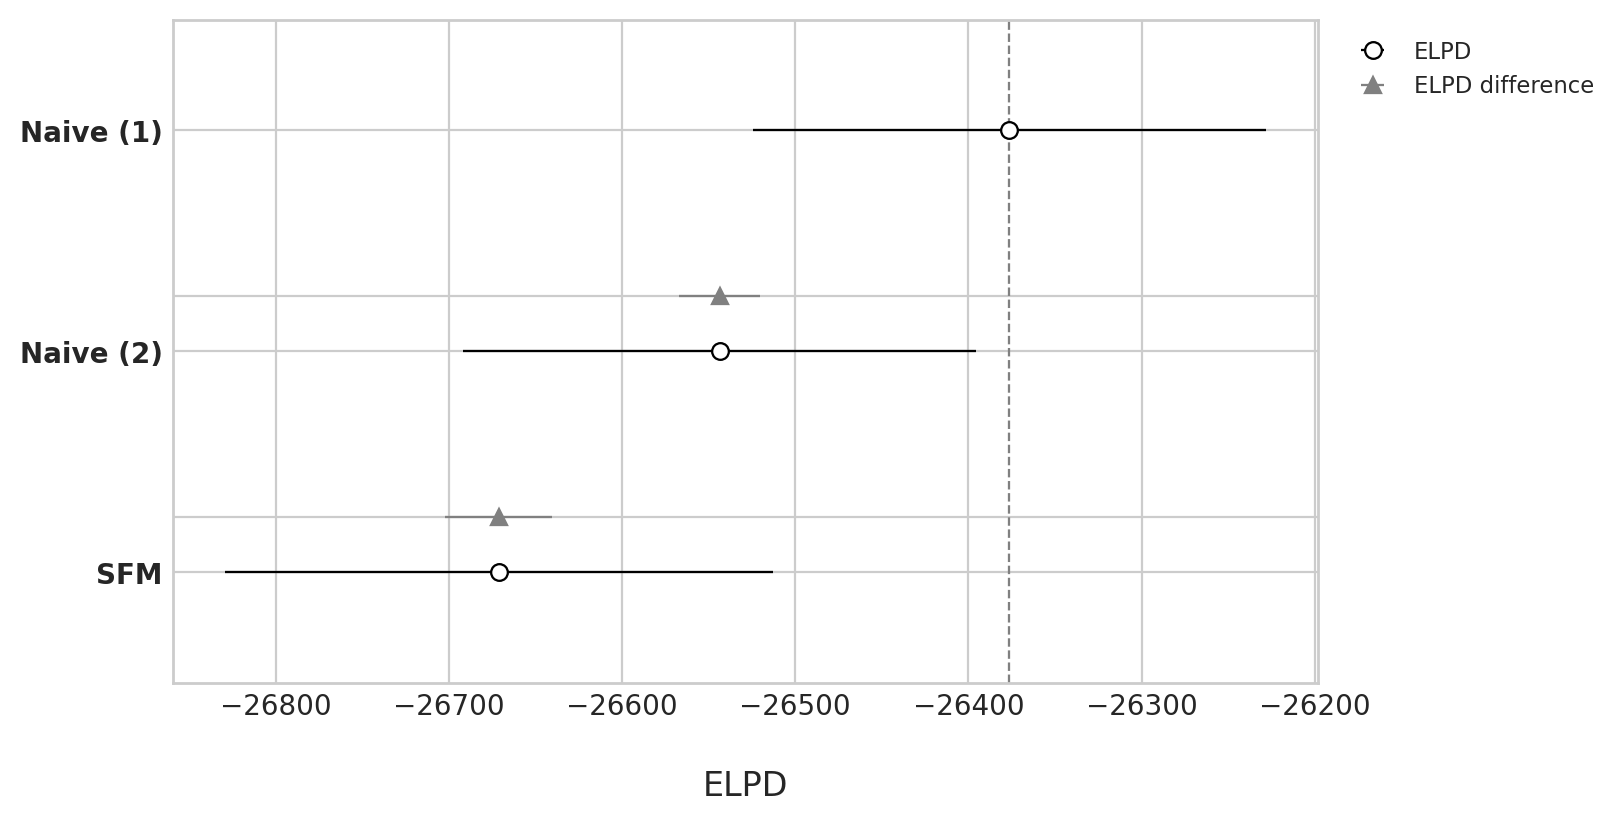

In [73]:
#fig, ax = plt.subplots(1, 1, figsize=(6,3.75))
fig, ax = plt.subplots(1, 1, figsize=(8,4))
az.plot_compare(df_loo, insample_dev=False, title=False, ax=ax)
plt.ylabel('')
plt.xlabel('\nELPD', size=12)
ax.tick_params(which='both',labelsize=10)
plt.yticks(weight='bold')
plt.show()

In [74]:
if 1==2:
    fig.savefig('../20_figures/LOOCV.png')

### Coverage Statistic

In [75]:
# ==================== For Compatibility: Compute Posterior Predictives for the Benchmark Models ==================== #

with SFM_naive1:
    idata_naive1.extend(pm.sample_posterior_predictive(idata_naive1))

with SFM_naive4:
    idata_naive4.extend(pm.sample_posterior_predictive(idata_naive4))



Sampling: [goals_scored]


Output()

Sampling: [goals_scored]


Output()

In [76]:
# --------------------------------------- USER INTERACTION --------------------------------------- #

# --- Which model do you you want to evaluate? ['SFM','naive1','naive2']
take_mod = 'naive2'

# --------------------------------------- USER INTERACTION --------------------------------------- #

for take_mod in ['SFM','naive1','naive2']:

    if take_mod == 'SFM':
        df = idata.copy()
    elif take_mod == 'naive1':
        df = idata_naive1.copy()
    elif take_mod == 'naive2':
        df = idata_naive4.copy()
    
    print(f'\n--------------------------- Selected Model: {take_mod} --------------------------- \n')
    y_hdi = az.hdi(df.posterior_predictive["goals_scored"])
    y_obs = df["observed_data"]["goals_scored"].to_numpy()
    is_within_hdi = (y_obs >= y_hdi.sel(hdi='lower')["goals_scored"].to_numpy()) & (y_obs <= y_hdi.sel(hdi='higher')["goals_scored"].to_numpy())
    print(f'Posterior 94% HDIs coverage: {np.round(is_within_hdi.mean()*100,2)}%')



--------------------------- Selected Model: SFM --------------------------- 

Posterior 94% HDIs coverage: 97.31%

--------------------------- Selected Model: naive1 --------------------------- 

Posterior 94% HDIs coverage: 97.24%

--------------------------- Selected Model: naive2 --------------------------- 

Posterior 94% HDIs coverage: 97.08%


### Class-Frequencies

In [77]:

# --------------------------------------- USER INTERACTION --------------------------------------- #

# --- Which model do you you want to evaluate? ['SFM','naive1','naive2']
take_mod = 'naive1'

# --------------------------------------- USER INTERACTION --------------------------------------- #

for take_mod in ['SFM','naive1','naive2']:

    if take_mod == 'SFM':
        df = idata.copy()
    elif take_mod == 'naive1':
        df = idata_naive1.copy()
    elif take_mod == 'naive2':
        df = idata_naive4.copy()
    
    
    
    """
       Given a number of goals G=0,1,2,3, which proportion of the observations ``y == G`` did the model predict correctly?
    """
    
    # --- Initialize the counter
    print(f'\n--------------------------- Selected Model: {take_mod} --------------------------- \n')
    all = 0
    all_g0 = 0
    for i in range(4):
        pct_per_class = np.mean(df.posterior_predictive['goals_scored'].where(df["observed_data"]["goals_scored"].to_numpy() == i) == i).to_numpy() * 100
        all += pct_per_class
        if i > 0:
            all_g0 += pct_per_class
        print(f'Accuracy --- # of Goals = {i}: {np.round(pct_per_class,2)}%')
    
    print(f'\nTotal Accuracy:         {np.round(all,2)}%')
    print(f'Accuracy (# Goals > 0): {np.round(all_g0,2)}%')


--------------------------- Selected Model: SFM --------------------------- 

Accuracy --- # of Goals = 0: 49.03%
Accuracy --- # of Goals = 1: 6.22%
Accuracy --- # of Goals = 2: 0.46%
Accuracy --- # of Goals = 3: 0.03%

Total Accuracy:         55.74%
Accuracy (# Goals > 0): 6.71%

--------------------------- Selected Model: naive1 --------------------------- 

Accuracy --- # of Goals = 0: 49.9%
Accuracy --- # of Goals = 1: 6.04%
Accuracy --- # of Goals = 2: 0.45%
Accuracy --- # of Goals = 3: 0.03%

Total Accuracy:         56.43%
Accuracy (# Goals > 0): 6.52%

--------------------------- Selected Model: naive2 --------------------------- 

Accuracy --- # of Goals = 0: 49.72%
Accuracy --- # of Goals = 1: 5.93%
Accuracy --- # of Goals = 2: 0.42%
Accuracy --- # of Goals = 3: 0.03%

Total Accuracy:         56.1%
Accuracy (# Goals > 0): 6.38%


## Versioning

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w